In [6]:
def get_decisions(robots):
    """
    Given a list of robot dictionaries, return a dict mapping each red robot's name
    (signal "red") to its decision ("reserve", "wait", "yield", "reroute", or "pause").

    Each robot dictionary should have:
      - name: string (unique identifier)
      - current: current node (string)
      - target: target node (string)
      - priority: one of "low", "medium", "high"
      - time_delay: float (in seconds)
      - signal: "red" or "green"
      - wait: list (if non-empty, robot has an associated wait node)
      - alt: list (alternate paths)

    Rules implemented:
      1. If a red robot's target node is reserved by any green robot (green's current),
         then set decision = "wait". Otherwise, tentatively set "reserve".
      2. Among red robots with the same target, only the best candidate (highest priority,
         then longer waiting time) gets "reserve" and others get "wait".
      3. For red robots, if its target equals another red robot’s current (i.e. reserved) node,
         and that robot’s target does not equal this robot's current, then set decision = "wait".
      4. If a red robot is in direct conflict (stand-off) with another red robot – meaning that
         each one's target equals the other’s reserved node – then:
             - The robot with lower priority (or lower wait time if priorities tie) gets "yield"
               (if it has a wait node; otherwise "wait").
             - The higher gets "reserve".
             - If both have no wait nodes and alternate paths exist, then the lower one may "reroute",
               or if unresolved, both may "pause".
      5. If a red robot has been waiting beyond a threshold and has an alternate path that is free
         (i.e. not reserved by any robot), then change its decision to "reroute".
    """
    # Map priority strings to numeric values for comparison.
    prio_map = {"low": 1, "medium": 2, "high": 3}

    red = [r for r in robots if r["signal"] == "red"]
    green = [r for r in robots if r["signal"] == "green"]

    decisions = {}

    # Build the set of reserved nodes from green robots.
    green_reserved = {g["current"] for g in green}

    # Step 1: For each red robot, if its target is in green reserved, then it must wait.
    # Otherwise, tentatively assign reserve.
    for r in red:
        if r["target"] in green_reserved:
            decisions[r["name"]] = "wait"
        else:
            decisions[r["name"]] = "reserve"

    # Step 2: Conflict among red robots targeting the same node.
    # Group red robots by target node.
    groups = {}
    for r in red:
        groups.setdefault(r["target"], []).append(r)
    for target, group in groups.items():
        if len(group) > 1:
            # Choose best candidate based on priority then time delay.
            candidate = max(group, key=lambda x: (prio_map[x["priority"]], x["time_delay"]))
            for r in group:
                decisions[r["name"]] = "reserve" if r["name"] == candidate["name"] else "wait"

    # Step 3: Check internal red conflicts where one red robot's target equals another's current.
    # This means one robot’s target is the reserved node of another red robot.
    for r in red:
        for other in red:
            if r["name"] == other["name"]:
                continue
            # If r's target equals other's current (i.e. reserved) node and
            # other's target is not equal to r's current, r must wait.
            if r["target"] == other["current"] and other["target"] != r["current"]:
                decisions[r["name"]] = "wait"

    # Step 4: Check for direct stand-off among red robots:
    # Stand-off condition: r1.target == r2.current AND r2.target == r1.current.
    for i in range(len(red)):
        for j in range(i+1, len(red)):
            r1 = red[i]
            r2 = red[j]
            if r1["target"] == r2["current"] and r2["target"] == r1["current"]:
                # Determine the winner using priority (and then time delay if equal)
                if prio_map[r1["priority"]] != prio_map[r2["priority"]]:
                    if prio_map[r1["priority"]] > prio_map[r2["priority"]]:
                        winner, loser = r1, r2
                    else:
                        winner, loser = r2, r1
                else:
                    # Same priority; use time_delay as tiebreaker (longer waiting wins)
                    if r1["time_delay"] >= r2["time_delay"]:
                        winner, loser = r1, r2
                    else:
                        winner, loser = r2, r1
                # The loser should "yield" if it has a wait node, otherwise "wait"
                decisions[loser["name"]] = "yield" if loser["wait"] else "wait"
                # Winner gets reserve.
                decisions[winner["name"]] = "reserve"

    # Step 5: Check for alternate path condition (reroute) for red robots that are waiting.
    # (Assume threshold time delay is e.g., 3 seconds)
    threshold = 3.0
    # Busy nodes: reserved by green and red (their current as reserved)
    busy_nodes = green_reserved.union({r["current"] for r in red})
    for r in red:
        if decisions[r["name"]] == "wait":
            if r["time_delay"] >= threshold and r["alt"]:
                # Choose an alternate that is free (not busy)
                free_alts = [alt for alt in r["alt"] if alt not in busy_nodes]
                if free_alts:
                    decisions[r["name"]] = "reroute"

    return decisions


# -----------------------------------------------------------------------------
# Define our sample scenarios:
# Each robot is represented as a dictionary with keys:
# name, current, target, priority, time_delay, signal, wait (list), alt (list)

# Sample System 1:
sample1 = [
    {
        "name": "A",
        "current": "C21",  # currently reserved
        "target": "C23",
        "priority": "low",
        "time_delay": 2.0,
        "signal": "red",
        "wait": ["W21"],
        "alt": []
    },
    {
        "name": "B",
        "current": "C20",
        "target": "C23",
        "priority": "high",
        "time_delay": 0.0,
        "signal": "green",
        "wait": ["W20"],
        "alt": []
    },
    {
        "name": "C",
        "current": "C19",
        "target": "C21",
        "priority": "medium",
        "time_delay": 1.5,
        "signal": "red",
        "wait": [],
        "alt": []
    }
]
# Expected: Robot A: reserve, Robot C: wait. (Robot B ignored as green)

# Sample System 2:
sample2 = [
    {
        "name": "A",
        "current": "C23",
        "target": "C24",
        "priority": "low",
        "time_delay": 0.0,
        "signal": "green",
        "wait": ["W23"],
        "alt": []
    },
    {
        "name": "B",
        "current": "C20",
        "target": "C23",
        "priority": "high",
        "time_delay": 1.0,
        "signal": "red",
        "wait": ["W20"],
        "alt": []
    },
    {
        "name": "C",
        "current": "C19",
        "target": "C21",
        "priority": "medium",
        "time_delay": 2.1,
        "signal": "red",
        "wait": [],
        "alt": []
    }
]
# Expected: Robot C: reserve, Robot B: wait. (Robot A ignored as green)

# Sample System 3:
sample3 = [
    {
        "name": "A",
        "current": "C23",
        "target": "C24",
        "priority": "low",
        "time_delay": 0.0,
        "signal": "green",
        "wait": ["W23"],
        "alt": []
    },
    {
        "name": "B",
        "current": "C20",
        "target": "C23",
        "priority": "high",
        "time_delay": 4.0,
        "signal": "red",
        "wait": ["W20"],
        "alt": ["C25"]
    },
    {
        "name": "C",
        "current": "C21",
        "target": "C26",
        "priority": "medium",
        "time_delay": 0.0,
        "signal": "green",
        "wait": ["W21"],
        "alt": []
    }
]
# Expected: Robot B should get "reroute" (as alternate path C25 is free) (others ignored)

# Sample System 4 (Stand-Off):
sample4 = [
    {
        "name": "A",
        "current": "C24",
        "target": "C25",
        "priority": "low",
        "time_delay": 0.3,
        "signal": "red",
        "wait": ["W24"],
        "alt": []
    },
    {
        "name": "B",
        "current": "C25",
        "target": "C24",
        "priority": "high",
        "time_delay": 4.0,
        "signal": "red",
        "wait": ["W25"],
        "alt": []
    },
    {
        "name": "C",
        "current": "C21",
        "target": "C26",
        "priority": "medium",
        "time_delay": 0.0,
        "signal": "green",
        "wait": ["W21"],
        "alt": []
    }
]
# Expected: Direct stand-off between A and B: B (high) gets "reserve", A gets "yield" (since it has a wait node).
# Robot C is ignored as green.

# -----------------------------------------------------------------------------
# Test the function with our four sample scenarios:
scenarios = [("Sample System 1", sample1),
             ("Sample System 2", sample2),
             ("Sample System 3", sample3),
             ("Sample System 4", sample4)]

for label, scenario in scenarios:
    decisions = get_decisions(scenario)
    print(f"{label} decisions:")
    for name, decision in decisions.items():
        print(f"  Robot {name}: {decision}")
    print()


Sample System 1 decisions:
  Robot A: reserve
  Robot C: wait

Sample System 2 decisions:
  Robot B: wait
  Robot C: reserve

Sample System 3 decisions:
  Robot B: reroute

Sample System 4 decisions:
  Robot A: yield
  Robot B: reserve



In [ ]:
import random
from typing import Any, Dict, List

# Action names for easier interpretation.
ACTION_NAMES = {0: "reserve", 1: "yield", 2: "wait", 3: "reroute", 4: "pause"}

def priority_to_str(priority: int) -> str:
    """
    Convert numeric priority to a string label.
    Mapping:
      1-3: low, 4-7: medium, 8-10: high.
    """
    if priority <= 3:
        return "low"
    elif priority <= 7:
        return "medium"
    else:
        return "high"

class SyntheticFleetSimulator:
    """
    Simulator for a fleet of robots generating synthetic JSON messages and computing
    ground truth decisions based on a set of traffic and conflict rules.

    Nodes follow the convention:
      - Checkpoints: "C<number>" (which may have an associated waitpoint "W<number>")

    Each robot message includes:
      - "trafficPathUpdates": which contains:
            - reservedNode: the current node the robot occupies (unique across robots).
            - nextNodeId: the desired target node.
            - waitNodeId: a wait area (if applicable).
            - timeDelay: the time the robot has been waiting.
            - alternatePaths: potential alternative target nodes.
            - signalLightStatus: "green" (in motion) or "red" (waiting for a decision).
      - "taskStatus": which contains a numeric priority.
    """

    def __init__(self, num_nodes: int = 50):
        # Create a pool of checkpoint nodes using the naming convention "C<number>".
        self.node_pool = [f"C{i}" for i in range(1, num_nodes + 1)]
        # For each checkpoint, define a corresponding waitpoint ("W<number>").
        self.waitpoint_map = {node: f"W{node[1:]}" for node in self.node_pool}
        # Define possible node types (only "checkpoint" supports wait nodes).
        self.node_types = ["checkpoint", "charge_dock", "home_dock", "station_dock", "elevator", "door"]

    def random_node(self) -> str:
        """Select a random node from the node pool."""
        return random.choice(self.node_pool)

    def get_wait_node(self, node: str, signal: str) -> List[str]:
        """
        Randomly return a one-item wait node if the chosen node type is "checkpoint" and signal is red.
        Otherwise, return an empty list.
        """
        node_type = random.choice(self.node_types) # ------------- "checkpoint"
        if node_type == "checkpoint" and signal == "red" and random.random() < 0.5: # -------------
            return [self.waitpoint_map[node]]
        return []

    def get_alternate_route(self) -> List[str]:
        """
        Randomly decide to provide an alternate route (one node) with 50% chance.
        Otherwise, return an empty list.
        """
        if random.random() < 0.5:
            return [random.choice(self.node_pool)]
        return []

    def generate_message(self, agent_id: str, signal: str, reserved_node: str) -> Dict[str, Any]:
        """
        Generate a synthetic JSON message for a robot.
        """
        next_node = self.random_node()
        time_delay = round(random.uniform(0.1, 5.0), 2)
        priority = random.randint(1, 10)
        alternate_paths = self.get_alternate_route()  # at most one alternate route
        wait_node = self.get_wait_node(reserved_node, signal)  # at most one wait node

        message = {
            "type": "common",
            "timestamp": "2024-12-02T10:15:00Z",
            "headerId": f"unique-message-id-{agent_id}",
            "zoneId": "fleet_1",
            "data": {
                "agentId": agent_id,
                "currentPosition": {
                    "x": round(random.uniform(0, 100), 2),
                    "y": round(random.uniform(0, 100), 2),
                    "theta": round(random.uniform(0, 360), 2)
                },
                "batteryLevel": random.randint(20, 100),
                "agentStatus": "online",
                "errorCodes": [],
                "taskStatus": {
                    "taskId": f"task_{random.randint(100,999)}",
                    "createdAt": "2019-08-24T14:15:22Z",
                    "executedAt": "2019-08-24T14:15:22Z",
                    "progress": random.randint(0, 100),
                    "priority": priority,
                    "loadCapacityKg": random.randint(5, 20),
                    "estimatedCompletionTime": "2024-11-20T14:30:00Z",
                    "taskBidUtilityValue": round(random.uniform(0.5, 1.0), 2),
                    "completedTaskHistory": [f"task_{random.randint(100,999)}" for _ in range(4)]
                },
                "trafficPathUpdates": {
                    "reservedNode": reserved_node,   # Unique current node.
                    "nextNodeId": next_node,           # Desired target node.
                    "waitNodeId": wait_node,           # Wait area if applicable.
                    "timeDelay": time_delay,           # How long the robot has been waiting.
                    "alternatePaths": alternate_paths,
                    "signalLightStatus": signal        # "green" or "red"
                },
                "plantResourceStatus": [
                    {"resourceType": "door", "resourceId": "door_01", "action_request": "open"},
                    {"resourceType": "elevator", "resourceId": "elevator_03", "action_request": "call"},
                    {"resourceType": "conveyor", "resourceId": "conveyor_02", "action_request": "call"}
                ]
            }
        }
        return message

    def generate_batch(self, num_robots: int) -> List[Dict[str, Any]]:
        """
        Generate a batch of synthetic messages for a given number of robots.
        Ensures that each robot gets a unique reserved node.
        """
        batch = []
        if num_robots > len(self.node_pool):
            raise ValueError("Number of robots cannot exceed the number of nodes for unique reserved nodes.")
        reserved_nodes = random.sample(self.node_pool, k=num_robots)
        for i in range(num_robots):
            signal = random.choice(["green", "red"]) # ------------ "red"
            msg = self.generate_message(f"AGV-{i:03d}", signal, reserved_nodes[i])
            batch.append(msg)
        return batch

    def get_decisions(self, batch: List[Dict[str, Any]]) -> Dict[str, str]:
        """
        Process the batch of messages and return a dict mapping each red robot's agentId to its decision.
        Decisions can be "reserve", "yield", "wait", "reroute", or "pause".

        The method first converts each message into a simpler robot dictionary with:
          - name: agentId
          - current: reservedNode
          - target: nextNodeId
          - priority: converted using priority_to_str()
          - time_delay: timeDelay
          - signal: signalLightStatus
          - wait: waitNodeId (list)
          - alt: alternatePaths (list)

        Then, it applies the following rules:
          1. If a red robot's target node is reserved by any green robot (green's current),
             then decision = "wait", else tentatively "reserve".
          2. Among red robots with the same target, the best candidate (highest priority, then longer waiting)
             gets "reserve" and the others get "wait".
          3. For red robots, if its target equals another red robot’s current (reserved) node, and that robot’s
             target does not equal this robot's current, then decision = "wait".
          4. For a direct stand-off (each robot’s target equals the other’s current), the one with lower priority
             (or shorter wait time if tied) gets "yield" (if it has a wait node; otherwise "wait"), and the other gets "reserve".
          5. Finally, if a red robot is waiting beyond a threshold (e.g., 3 seconds) and has an alternate path available
             that is not reserved, then change its decision to "reroute".
        """
        prio_map = {"low": 1, "medium": 2, "high": 3}

        # Convert messages into a simplified robot representation.
        robots = []
        for msg in batch:
            data = msg["data"]
            tp = data["trafficPathUpdates"]
            robot = {
                "name": data["agentId"],
                "current": tp["reservedNode"],
                "target": tp["nextNodeId"],
                "priority": priority_to_str(data["taskStatus"]["priority"]),
                "time_delay": tp["timeDelay"],
                "signal": tp["signalLightStatus"],
                "wait": tp["waitNodeId"],
                "alt": tp["alternatePaths"]
            }
            robots.append(robot)

        # Split robots into red (request) and green (operation).
        red = [r for r in robots if r["signal"] == "red"]
        green = [r for r in robots if r["signal"] == "green"]
        decisions = {}

        # Build set of reserved nodes from green robots.
        green_reserved = {g["current"] for g in green}

        # Step 1: For each red robot, if its target is in green reserved, then set decision to "wait".
        # Otherwise, tentatively assign "reserve".
        for r in red:
            if r["target"] in green_reserved:
                decisions[r["name"]] = "wait"
            else:
                decisions[r["name"]] = "reserve"

        # Step 2: For red robots with the same target, pick the best candidate (by priority then time_delay).
        groups = {}
        for r in red:
            groups.setdefault(r["target"], []).append(r)
        for target, group in groups.items():
            if len(group) > 1:
                candidate = max(group, key=lambda x: (prio_map[x["priority"]], x["time_delay"]))
                for r in group:
                    decisions[r["name"]] = "reserve" if r["name"] == candidate["name"] else "wait"

        # Step 3: For internal red conflicts, if a red robot's target equals another red robot's current (reserved)
        # and that other robot's target is not equal to the first robot's current, set decision to "wait".
        for r in red:
            for other in red:
                if r["name"] == other["name"]:
                    continue
                if r["target"] == other["current"] and other["target"] != r["current"]:
                    decisions[r["name"]] = "wait"

        # Step 4: Check for direct stand-off among red robots:
        # Stand-off: r1.target == r2.current AND r2.target == r1.current.
        for i in range(len(red)):
            for j in range(i + 1, len(red)):
                r1 = red[i]
                r2 = red[j]
                if r1["target"] == r2["current"] and r2["target"] == r1["current"]:
                    # Determine winner by priority and then by time_delay.
                    if prio_map[r1["priority"]] != prio_map[r2["priority"]]:
                        winner, loser = (r1, r2) if prio_map[r1["priority"]] > prio_map[r2["priority"]] else (r2, r1)
                    else:
                        winner, loser = (r1, r2) if r1["time_delay"] >= r2["time_delay"] else (r2, r1)
                    decisions[loser["name"]] = "yield" if loser["wait"] else "wait"
                    decisions[winner["name"]] = "reserve"

        # Step 5: Check for alternate path (reroute) for red robots waiting beyond a threshold.
        threshold = 0.5
        busy_nodes = green_reserved.union({r["current"] for r in red})
        for r in red:
            if decisions[r["name"]] == "wait":
                if r["time_delay"] >= threshold and r["alt"]:
                    free_alts = [alt for alt in r["alt"] if alt not in busy_nodes]
                    if free_alts:
                        decisions[r["name"]] = "reroute"

        return decisions





# --------------------------
# Example usage:
# --------------------------
if __name__ == "__main__":
    # Specify a small system: 7 nodes, 3 robots.
    simulator = SyntheticFleetSimulator(num_nodes=7)
    batch = simulator.generate_batch(3)

    # Count red (request) messages.
    red_count = sum(1 for msg in batch if msg["data"]["trafficPathUpdates"]["signalLightStatus"] == "red")
    print(f"Total robots: {len(batch)} | Red (request) messages: {red_count}\n")

    # Print key details for each robot.
    print("Robot Summaries:")
    for msg in batch:
        data = msg["data"]
        agent = data["agentId"]
        current_node = data["trafficPathUpdates"]["reservedNode"]
        target_node = data["trafficPathUpdates"]["nextNodeId"]
        priority = data["taskStatus"]["priority"]
        prio_str = priority_to_str(priority)
        time_delay = data["trafficPathUpdates"]["timeDelay"]
        signal = data["trafficPathUpdates"]["signalLightStatus"]
        wait_nodes = data["trafficPathUpdates"]["waitNodeId"]
        alt_paths = data["trafficPathUpdates"]["alternatePaths"]
        print(f"{agent}: current node {current_node}. target node {target_node}. "
              f"task priority {prio_str}. timedelay {time_delay} sec. signal {signal}. "
              f"waitNodeId {wait_nodes}. alternate path {alt_paths}.")

    # Compute decisions for red (request) messages.
    decisions = simulator.get_decisions(batch)
    print("\nSupervised Targets (agentId: decision):")
    for agent, decision in decisions.items():
        print(f"{agent}: {decision}")


Total robots: 3 | Red (request) messages: 3

Robot Summaries:
AGV-000: current node C5. target node C7. task priority medium. timedelay 3.33 sec. signal red. waitNodeId ['W5']. alternate path ['C5'].
AGV-001: current node C6. target node C3. task priority high. timedelay 3.02 sec. signal red. waitNodeId ['W6']. alternate path ['C2'].
AGV-002: current node C3. target node C6. task priority high. timedelay 4.15 sec. signal red. waitNodeId ['W3']. alternate path [].

Supervised Targets (agentId: decision):
AGV-000: reserve
AGV-001: yield
AGV-002: reserve


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from torch_geometric.nn import GCNConv, TransformerConv, TopKPooling
from torch_geometric.data import Data, Batch

###############################
# Utility Functions and Types
###############################
def priority_to_str(priority: int) -> str:
    """Converts numeric priority to a label: low (1-3), medium (4-7), high (8-10)."""
    if priority <= 3:
        return "low"
    elif priority <= 7:
        return "medium"
    else:
        return "high"

###############################
# Synthetic Fleet Simulator
###############################
# (This is largely as before; we assume it produces JSON-like messages from robots.)
class SyntheticFleetSimulator:
    def __init__(self, num_nodes: int = 50):
        self.node_pool = [f"C{i}" for i in range(1, num_nodes + 1)]
        self.waitpoint_map = {node: f"W{node[1:]}" for node in self.node_pool}
        self.node_types = ["checkpoint", "charge_dock", "home_dock", "station_dock", "elevator", "door"]

    def random_node(self) -> str:
        return random.choice(self.node_pool)

    def get_wait_node(self, node: str, signal: str) -> list:
        node_type = random.choice(self.node_types)
        if node_type == "checkpoint" and signal == "red" and random.random() < 0.5:
            return [self.waitpoint_map[node]]
        return []

    def get_alternate_route(self) -> list:
        if random.random() < 0.5:
            return [random.choice(self.node_pool)]
        return []

    def generate_message(self, agent_id: str, signal: str, reserved_node: str) -> dict:
        next_node = self.random_node()
        time_delay = round(random.uniform(0.1, 5.0), 2)
        priority = random.randint(1, 10)
        alternate_paths = self.get_alternate_route()
        wait_node = self.get_wait_node(reserved_node, signal)
        message = {
            "type": "common",
            "timestamp": "2024-12-02T10:15:00Z",
            "headerId": f"unique-message-id-{agent_id}",
            "zoneId": "fleet_1",
            "data": {
                "agentId": agent_id,
                "trafficPathUpdates": {
                    "reservedNode": reserved_node,
                    "nextNodeId": next_node,
                    "waitNodeId": wait_node,
                    "timeDelay": time_delay,
                    "alternatePaths": alternate_paths,
                    "signalLightStatus": signal
                },
                "taskStatus": {
                    "priority": priority
                }
            }
        }
        return message

    def generate_batch(self, num_robots: int) -> list:
        batch = []
        if num_robots > len(self.node_pool):
            raise ValueError("Number of robots cannot exceed unique reserved nodes.")
        reserved_nodes = random.sample(self.node_pool, k=num_robots)
        for i in range(num_robots):
            signal = random.choice(["green", "red"])
            msg = self.generate_message(f"AGV-{i:03d}", signal, reserved_nodes[i])
            batch.append(msg)
        return batch

####################################
# Transformer with Causal Self-Attention
####################################
class CausalSelfAttention(nn.Module):
    """
    A causal self-attention module.
    Inspired by your provided GPT example.
    """
    def __init__(self, n_embd, n_head, dropout=0.1):
        super().__init__()
        assert n_embd % n_head == 0, "Embedding dimension must be divisible by number of heads"
        self.n_head = n_head
        self.head_dim = n_embd // n_head
        self.c_attn = nn.Linear(n_embd, 3 * n_embd)  # query, key, value projections
        self.c_proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: (B, T, n_embd)
        B, T, C = x.size()
        qkv = self.c_attn(x)  # (B, T, 3*n_embd)
        q, k, v = qkv.split(C, dim=2)
        # reshape and transpose for multi-head attention
        q = q.view(B, T, self.n_head, self.head_dim).transpose(1, 2)  # (B, n_head, T, head_dim)
        k = k.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        # scaled dot-product attention with causal mask
        attn_weights = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)  # (B, n_head, T, T)
        # create a causal mask: allow attention only to previous positions (including current)
        causal_mask = torch.tril(torch.ones(T, T, device=x.device)).unsqueeze(0).unsqueeze(0)
        attn_weights = attn_weights.masked_fill(causal_mask == 0, float('-inf'))
        attn = F.softmax(attn_weights, dim=-1)
        attn = self.dropout(attn)
        y = torch.matmul(attn, v)  # (B, n_head, T, head_dim)
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.c_proj(y)
        return y

class MLP(nn.Module):
    """
    A simple multilayer perceptron used inside a transformer block.
    """
    def __init__(self, n_embd):
        super().__init__()
        self.fc1 = nn.Linear(n_embd, 4 * n_embd)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(4 * n_embd, n_embd)

    def forward(self, x):
        return self.fc2(self.act(self.fc1(x)))

class TransformerBlock(nn.Module):
    """
    A transformer block consisting of a layer-norm, causal self-attention, and an MLP.
    """
    def __init__(self, n_embd, n_head, dropout=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embd)
        self.attn = CausalSelfAttention(n_embd, n_head, dropout)
        self.ln2 = nn.LayerNorm(n_embd)
        self.mlp = MLP(n_embd)

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class FleetTransformer(nn.Module):
    """
    A stack of transformer blocks.
    """
    def __init__(self, n_blocks, n_embd, n_head, dropout=0.1):
        super().__init__()
        self.blocks = nn.ModuleList([TransformerBlock(n_embd, n_head, dropout) for _ in range(n_blocks)])
        self.ln_f = nn.LayerNorm(n_embd)

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return self.ln_f(x)

####################################
# Graph Encoders for Fleet Messages
####################################
class GraphEncoder(nn.Module):
    """
    A graph encoder using a two-layer GCN.
    This is used to embed robot messages (features) into a fixed-dimension vector.
    """
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data: Data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x  # shape: (num_nodes, out_channels)

####################################
# Decision Head (Output Mapping)
####################################
class GraphDecisionHead(nn.Module):
    """
    Maps transformer outputs to decision logits.
    The decisions (e.g., reserve, yield, wait, reroute, pause) are output as logits.
    """
    def __init__(self, in_channels, hidden_channels, num_decisions=5):
        super().__init__()
        self.fc1 = nn.Linear(in_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, num_decisions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)
        return logits

####################################
# Central Fleet Management Model
####################################
class CentralFleetModel(nn.Module):
    """
    This model fuses two graph encoders (for green and red robot messages) with a transformer
    that captures interactions. Finally, the decision head outputs a decision for each red (requesting) robot.

    Workflow:
      1. Process green (operation) and red (request) robot messages with their respective graph encoders.
      2. Project their embeddings into a common space.
      3. Concatenate the projected embeddings and process them with a transformer (FleetTransformer).
      4. Extract the embeddings corresponding to red robots and map them to decision logits.
    """
    def __init__(self,
                 node_feature_dim=16,
                 graph_hidden_dim=32,
                 graph_out_dim=64,
                 transformer_n_blocks=2,
                 transformer_n_embd=64,
                 transformer_n_head=4,
                 decision_hidden_dim=32,
                 num_decisions=5):
        super().__init__()
        # Graph encoders for both groups
        self.operation_encoder = GraphEncoder(node_feature_dim, graph_hidden_dim, graph_out_dim)
        self.request_encoder = GraphEncoder(node_feature_dim, graph_hidden_dim, graph_out_dim)

        # Linear projections to transformer embedding space
        self.op_projection = nn.Linear(graph_out_dim, transformer_n_embd)
        self.req_projection = nn.Linear(graph_out_dim, transformer_n_embd)

        # Transformer to fuse features (both groups)
        self.transformer = FleetTransformer(transformer_n_blocks, transformer_n_embd, transformer_n_head)

        # Decision head: Only for request robots (red)
        self.decision_head = GraphDecisionHead(transformer_n_embd, decision_hidden_dim, num_decisions)

    def forward(self, op_data: Data, req_data: Data):
        # Encode graph features
        op_embedding = self.operation_encoder(op_data)  # (n_op, graph_out_dim)
        req_embedding = self.request_encoder(req_data)    # (n_req, graph_out_dim)

        # Project into transformer space
        op_proj = self.op_projection(op_embedding)  # (n_op, transformer_n_embd)
        req_proj = self.req_projection(req_embedding)  # (n_req, transformer_n_embd)

        # Concatenate embeddings into one sequence; note the order (op first, then req)
        combined = torch.cat([op_proj, req_proj], dim=0)  # (n_total, transformer_n_embd)
        combined = combined.unsqueeze(0)  # add batch dim -> (1, n_total, transformer_n_embd)

        # Transformer to capture inter-dependencies (attention mechanism is inside)
        transformer_out = self.transformer(combined)  # (1, n_total, transformer_n_embd)
        transformer_out = transformer_out.squeeze(0)   # (n_total, transformer_n_embd)

        # Separate out the request part (assuming request nodes come after op nodes)
        n_op = op_proj.shape[0]
        req_out = transformer_out[n_op:]

        # Decision head mapping
        decision_logits = self.decision_head(req_out)  # (n_req, num_decisions)
        return decision_logits

####################################
# Supervised Learning Trainer (SL)
####################################
class SLTrainer:
    """
    Supervised training pipeline using cross-entropy loss.
    Human feedback integration is possible via an update_feedback() method.
    """
    def __init__(self, model: CentralFleetModel, learning_rate=1e-3):
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.criterion = nn.CrossEntropyLoss()

    def train_step(self, op_data: Data, req_data: Data, target_labels: torch.Tensor):
        self.model.train()
        self.optimizer.zero_grad()
        logits = self.model(op_data, req_data)  # (n_req, num_decisions)
        loss = self.criterion(logits, target_labels)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def inference(self, op_data: Data, req_data: Data):
        self.model.eval()
        with torch.no_grad():
            logits = self.model(op_data, req_data)
            predictions = torch.argmax(logits, dim=1)
        return predictions

    def update_feedback(self, feedback_dict: dict):
        """
        Incorporate human feedback to adjust the model.
        feedback_dict maps request robot IDs (or indices) to corrected decision labels.
        This is a stub that, in a real system, would modify the training data or fine-tune the model.
        """
        # Example: log feedback and adjust a feedback loss term.
        print("Received human feedback:", feedback_dict)
        # Placeholder: use the feedback to adjust loss weights or sample importance.

####################################
# Reinforcement Learning Trainer (RL)
####################################
class RLTrainer:
    """
    Reinforcement learning trainer using policy gradients.
    Includes reward shaping, penalty terms, episode simulation and termination conditions.
    Human feedback is integrated into the update step.
    """
    def __init__(self, model: CentralFleetModel, learning_rate=1e-4, gamma=0.99, max_episode_steps=50):
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.gamma = gamma  # Discount factor for rewards
        self.max_episode_steps = max_episode_steps

    def select_actions(self, op_data: Data, req_data: Data):
        """
        Perform forward pass, return sampled actions along with log probabilities and entropy.
        """
        logits = self.model(op_data, req_data)  # (n_req, num_decisions)
        dist = torch.distributions.Categorical(logits=logits)
        actions = dist.sample()  # (n_req,)
        return actions, dist.log_prob(actions), dist.entropy()

    def compute_rewards(self, actions, op_data: Data, req_data: Data):
        """
        Compute a reward signal for each request robot.
        Here we provide a placeholder logic:
          - Reward is high if the decision leads to no conflict.
          - Apply penalty if a decision is unsafe or if multiple requests conflict.
          - In a complete system, the reward would be based on fleet simulation outcomes.
        """
        # Dummy reward: reward of 1.0 for "reserve" (index 0) and 0.5 for others,
        # plus a penalty if conflicting (this is a placeholder).
        rewards = torch.where(actions == 0, torch.tensor(1.0), torch.tensor(0.5))
        # For demonstration, add a random penalty sometimes.
        penalty = (torch.rand_like(rewards) < 0.1).float() * -0.5
        return rewards + penalty

    def rollout_episode(self, op_data: Data, req_data: Data):
        """
        Simulate one episode of decisions.
        Collect log probabilities and rewards at each step.
        Terminate if episode length exceeds max_episode_steps.
        """
        log_probs_list = []
        rewards_list = []
        step = 0
        done = False

        while not done and step < self.max_episode_steps:
            actions, log_probs, entropy = self.select_actions(op_data, req_data)
            rewards = self.compute_rewards(actions, op_data, req_data)
            log_probs_list.append(log_probs)
            rewards_list.append(rewards)
            # Placeholder: update observations or environment here if needed.
            # In a real system, you would update op_data/req_data based on decisions.
            step += 1
            # Termination condition: for example, if average reward exceeds a threshold.
            if rewards.mean() > 0.9:
                done = True

        return log_probs_list, rewards_list

    def update_policy(self, log_probs_list, rewards_list, human_feedback=None):
        """
        Update policy via a policy gradient loss.
        Optionally incorporate human feedback to adjust the reward signal.
        """
        # Compute discounted rewards for each timestep.
        discounted_rewards = []
        for rewards in rewards_list:
            R = 0
            dr = []
            for r in reversed(rewards):
                R = r + self.gamma * R
                dr.insert(0, R)
            discounted_rewards.extend(dr)
        discounted_rewards = torch.tensor(discounted_rewards)
        # Normalize rewards
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-8)

        # Sum up log probabilities from all timesteps.
        log_probs = torch.cat(log_probs_list)
        policy_loss = -torch.sum(log_probs * discounted_rewards)

        # Incorporate human feedback: for instance, boost the reward for corrected actions.
        if human_feedback:
            # human_feedback is assumed to be a dict mapping timestep indices to bonus rewards.
            feedback_bonus = sum(human_feedback.get(i, 0.0) for i in range(len(discounted_rewards)))
            policy_loss -= feedback_bonus  # reward bonus lowers the loss

        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()
        return policy_loss.item()

####################################
# Example Usage and Integration
####################################
if __name__ == "__main__":
    # Assume we generate a small batch from the simulator.
    simulator = SyntheticFleetSimulator(num_nodes=7)
    batch = simulator.generate_batch(3)

    # For demonstration, we separate green and red messages.
    op_msgs = [msg for msg in batch if msg["data"]["trafficPathUpdates"]["signalLightStatus"] == "green"]
    req_msgs = [msg for msg in batch if msg["data"]["trafficPathUpdates"]["signalLightStatus"] == "red"]
    # In our example, assume all are red if none are green.
    if len(op_msgs) == 0:
        op_msgs = batch[:1]
    if len(req_msgs) == 0:
        req_msgs = batch

    # Dummy conversion: create node features from messages.
    # Here, each node feature is a random vector; in practice, this should be derived from the message content.
    node_feature_dim = 16
    op_x = torch.randn((len(op_msgs), node_feature_dim))
    req_x = torch.randn((len(req_msgs), node_feature_dim))

    # Dummy fully-connected edge indices for graphs.
    op_edge_index = torch.tensor([[i, j] for i in range(len(op_msgs)) for j in range(len(op_msgs)) if i != j], dtype=torch.long).t().contiguous()
    req_edge_index = torch.tensor([[i, j] for i in range(len(req_msgs)) for j in range(len(req_msgs)) if i != j], dtype=torch.long).t().contiguous()

    op_data = Data(x=op_x, edge_index=op_edge_index)
    req_data = Data(x=req_x, edge_index=req_edge_index)

    # Initialize the central fleet model.
    central_model = CentralFleetModel(
        node_feature_dim=node_feature_dim,
        graph_hidden_dim=32,
        graph_out_dim=64,
        transformer_n_blocks=2,
        transformer_n_embd=64,
        transformer_n_head=4,
        decision_hidden_dim=32,
        num_decisions=5
    )

    # ---- Supervised Learning Example ----
    sl_trainer = SLTrainer(central_model, learning_rate=1e-3)
    # Dummy target labels (for example: 0: reserve, 1: yield, 2: wait, 3: reroute, 4: pause).
    target_labels = torch.tensor([0 for _ in range(req_x.shape[0])], dtype=torch.long)
    sl_loss = sl_trainer.train_step(op_data, req_data, target_labels)
    print("SL Training Loss:", sl_loss)
    sl_predictions = sl_trainer.inference(op_data, req_data)
    print("SL Predictions:", sl_predictions.tolist())

    # ---- Reinforcement Learning Example ----
    rl_trainer = RLTrainer(central_model, learning_rate=1e-4, gamma=0.99, max_episode_steps=5)
    log_probs_list, rewards_list = rl_trainer.rollout_episode(op_data, req_data)
    # Simulate human feedback as a bonus for timestep 2 (example).
    human_feedback = {2: 0.2}
    rl_loss = rl_trainer.update_policy(log_probs_list, rewards_list, human_feedback)
    print("RL Policy Update Loss:", rl_loss)


In [135]:

# v1.


import random
from typing import Any, Dict, List

# Action names for easier interpretation.
ACTION_NAMES = {0: "reserve", 1: "yield", 2: "wait", 3: "reroute", 4: "pause"}

def priority_to_str(priority: int) -> str:
    """
    Convert numeric priority to a string label.
    Mapping:
      1-3: low, 4-7: medium, 8-10: high.
    """
    if priority <= 3:
        return "low"
    elif priority <= 7:
        return "medium"
    else:
        return "high"

class SyntheticFleetSimulator:
    """
    Simulator for a fleet of robots generating synthetic JSON messages and computing
    ground truth decisions based on a set of traffic and conflict rules.

    Nodes follow the convention:
      - Checkpoints: "C<number>" (which may have an associated waitpoint "W<number>")

    Each robot message includes:
      - "trafficPathUpdates": which contains:
            - reservedNode: the current node the robot occupies (unique across robots).
            - nextNodeId: the desired target node.
            - waitNodeId: a wait area (if applicable).
            - timeDelay: the time the robot has been waiting.
            - alternatePaths: potential alternative target nodes.
            - signalLightStatus: "green" (in motion) or "red" (waiting for a decision).
      - "taskStatus": which contains a numeric priority.
    """

    def __init__(self, num_nodes: int = 50):
        # Create a pool of checkpoint nodes using the naming convention "C<number>".
        self.node_pool = [f"C{i}" for i in range(1, num_nodes + 1)]
        # For each checkpoint, define a corresponding waitpoint ("W<number>").
        self.waitpoint_map = {node: f"W{node[1:]}" for node in self.node_pool}
        # Define possible node types (only "checkpoint" supports wait nodes).
        self.node_types = ["checkpoint", "charge_dock", "home_dock", "station_dock", "elevator", "door"]

    def random_node(self) -> str:
        """Select a random node from the node pool."""
        return random.choice(self.node_pool)

    def get_wait_node(self, node: str, signal: str) -> List[str]:
        """
        Randomly return a one-item wait node if the chosen node type is "checkpoint" and signal is red.
        Otherwise, return an empty list.
        """
        node_type = random.choice(self.node_types) # ------------- "checkpoint"
        if node_type == "checkpoint" and signal == "red" and random.random() < 0.5: # -------------
            return [self.waitpoint_map[node]]
        return []

    def get_alternate_route(self) -> List[str]:
        """
        Randomly decide to provide an alternate route (one node) with 50% chance.
        Otherwise, return an empty list.
        """
        if random.random() < 0.5:
            return [random.choice(self.node_pool)]
        return []

    def generate_message(self, agent_id: str, signal: str, reserved_node: str) -> Dict[str, Any]:
        """
        Generate a synthetic JSON message for a robot.
        """
        next_node = self.random_node()
        time_delay = round(random.uniform(0.1, 5.0), 2)
        priority = random.randint(1, 10)
        alternate_paths = self.get_alternate_route()  # at most one alternate route
        wait_node = self.get_wait_node(reserved_node, signal)  # at most one wait node

        message = {
            "type": "common",
            "timestamp": "2024-12-02T10:15:00Z",
            "headerId": f"unique-message-id-{agent_id}",
            "zoneId": "fleet_1",
            "data": {
                "agentId": agent_id,
                "currentPosition": {
                    "x": round(random.uniform(0, 100), 2),
                    "y": round(random.uniform(0, 100), 2),
                    "theta": round(random.uniform(0, 360), 2)
                },
                "batteryLevel": random.randint(20, 100),
                "agentStatus": "online",
                "errorCodes": [],
                "taskStatus": {
                    "taskId": f"task_{random.randint(100,999)}",
                    "createdAt": "2019-08-24T14:15:22Z",
                    "executedAt": "2019-08-24T14:15:22Z",
                    "progress": random.randint(0, 100),
                    "priority": priority,
                    "loadCapacityKg": random.randint(5, 20),
                    "estimatedCompletionTime": "2024-11-20T14:30:00Z",
                    "taskBidUtilityValue": round(random.uniform(0.5, 1.0), 2),
                    "completedTaskHistory": [f"task_{random.randint(100,999)}" for _ in range(4)]
                },
                "trafficPathUpdates": {
                    "reservedNode": reserved_node,   # Unique current node.
                    "nextNodeId": next_node,           # Desired target node.
                    "waitNodeId": wait_node,           # Wait area if applicable.
                    "timeDelay": time_delay,           # How long the robot has been waiting.
                    "alternatePaths": alternate_paths,
                    "signalLightStatus": signal        # "green" or "red"
                },
                "plantResourceStatus": [
                    {"resourceType": "door", "resourceId": "door_01", "action_request": "open"},
                    {"resourceType": "elevator", "resourceId": "elevator_03", "action_request": "call"},
                    {"resourceType": "conveyor", "resourceId": "conveyor_02", "action_request": "call"}
                ]
            }
        }
        return message

    def generate_batch(self, num_robots: int) -> List[Dict[str, Any]]:
        """
        Generate a batch of synthetic messages for a given number of robots.
        Ensures that each robot gets a unique reserved node.
        """
        batch = []
        if num_robots > len(self.node_pool):
            raise ValueError("Number of robots cannot exceed the number of nodes for unique reserved nodes.")
        reserved_nodes = random.sample(self.node_pool, k=num_robots)
        for i in range(num_robots):
            signal = random.choice(["green", "red"]) # ------------ "red"
            msg = self.generate_message(f"AGV-{i:03d}", signal, reserved_nodes[i])
            batch.append(msg)
        return batch


    # v3
    def get_decisions(self, batch: List[Dict[str, Any]]) -> Dict[str, str]:
        """
        Process the batch of messages and return a dict mapping each red robot's agentId
        to its decision. This upgraded function scales beyond 3 robots by using a global
        ordering of red (request) robots based on effective priority (priority level and waiting time)
        and sequentially “locking” target nodes. It then builds a conflict graph and resolves any conflicts
        (both non-mutual conflicts and direct stand-offs) iteratively until decisions stabilize.

        Decisions:
        - "reserve": robot is granted its target (or alternate) node.
        - "wait": robot must wait at its current position.
        - "reroute": robot will take an alternate route.
        - "yield": in a stand-off conflict, the robot that must back down.
        - "pause": both robots in a stand-off have no alternatives, triggering human help.

        Edge Case:
        - If a red robot's current node equals its target node, it is already at its desired position,
            so it is immediately given a "reserve" decision.
        """
        # Map string priorities to numeric values for comparison.
        prio_map = {"low": 1, "medium": 2, "high": 3}

        # ----------------------------
        # Step 0: Preprocess robots
        # ----------------------------
        # Build a simplified list of robot dictionaries.
        robots = []
        for msg in batch:
            data = msg["data"]
            tp = data["trafficPathUpdates"]
            robot = {
                "name": data["agentId"],
                "current": tp["reservedNode"],
                "target": tp["nextNodeId"],
                "priority": priority_to_str(data["taskStatus"]["priority"]),
                "time_delay": tp["timeDelay"],
                "signal": tp["signalLightStatus"],
                "wait": tp["waitNodeId"],       # List of wait nodes (if any)
                "alt": tp["alternatePaths"]      # List of alternate paths (if any)
            }
            robots.append(robot)

        # Separate red (waiting for decision) robots from green (in motion).
        red = [r for r in robots if r["signal"] == "red"]
        green = [r for r in robots if r["signal"] == "green"]

        decisions = {}      # Final mapping: agentId -> decision.
        locked_nodes = {}   # Map of node -> agentId that has locked that node.

        # Build a set of nodes already reserved (occupied) by green robots.
        green_reserved = {g["current"] for g in green}

        # ----------------------------
        # Step 1: Sequential Locking via Global Sorting
        # ----------------------------
        # Compute effective priority for red robots: (numeric priority, time_delay).
        # Higher numeric value and longer waiting time are better.
        red_sorted = sorted(red, key=lambda r: (prio_map[r["priority"]], r["time_delay"]), reverse=True)

        # Define a threshold for considering alternate paths.
        threshold = 0.5

        # Process each red robot (best effective priority first)
        for r in red_sorted:
            # Edge case: if the robot is already at its target node,
            # simply grant it "reserve" and lock that node.
            if r["current"] == r["target"]:
                decisions[r["name"]] = "reserve"
                locked_nodes[r["target"]] = r["name"]
                continue

            # Otherwise, try to lock the desired target if it's not already taken.
            if r["target"] not in green_reserved and r["target"] not in locked_nodes:
                decisions[r["name"]] = "reserve"
                locked_nodes[r["target"]] = r["name"]
            else:
                decisions[r["name"]] = "wait"

            # Check if the robot qualifies for a reroute: if waiting beyond the threshold and has an alternate.
            if decisions[r["name"]] == "wait" and r["time_delay"] >= threshold and r["alt"]:
                free_alts = [alt for alt in r["alt"] if alt not in green_reserved and alt not in locked_nodes]
                if free_alts:
                    decisions[r["name"]] = "reroute"
                    locked_nodes[free_alts[0]] = r["name"]

        # ----------------------------
        # Step 2: Build and Resolve Conflict Graph
        # ----------------------------
        # We now resolve two types of conflicts:
        #   (a) Non-mutual conflicts: where a red robot's target equals another red robot's current node,
        #       but that other robot is not switching back.
        #   (b) Direct stand-offs: two red robots with each other's current node as their target.
        # Iterate until no decision changes occur.
        changed = True
        while changed:
            changed = False

            # (a) Resolve conflicts among red robots competing for the same target.
            target_groups = {}
            for r in red:
                # Skip edge-case robots already at their target.
                if r["current"] == r["target"]:
                    continue
                if decisions[r["name"]] in ["reserve", "reroute"]:
                    target_groups.setdefault(r["target"], []).append(r)
            for target, group in target_groups.items():
                if len(group) > 1:
                    # Select the best candidate in the group.
                    best = max(group, key=lambda r: (prio_map[r["priority"]], r["time_delay"]))
                    for r in group:
                        if r["name"] != best["name"]:
                            if decisions[r["name"]] != "wait":
                                decisions[r["name"]] = "wait"
                                if target in locked_nodes and locked_nodes[target] == r["name"]:
                                    del locked_nodes[target]
                                changed = True

            # (b) Resolve non-mutual conflicts.
            for r in red:
                # Skip edge-case robots that already are at their target.
                if r["current"] == r["target"]:
                    continue
                for other in red:
                    if r["name"] == other["name"]:
                        continue
                    if r["target"] == other["current"] and other["target"] != r["current"]:
                        if decisions[r["name"]] != "wait":
                            decisions[r["name"]] = "wait"
                            if r["target"] in locked_nodes and locked_nodes[r["target"]] == r["name"]:
                                del locked_nodes[r["target"]]
                            changed = True

            # (c) Resolve direct stand-off conflicts.
            # Stand-off: r1.target == r2.current  and  r2.target == r1.current.
            for i in range(len(red)):
                for j in range(i + 1, len(red)):
                    r1 = red[i]
                    r2 = red[j]
                    # Skip if either is in the edge case (current equals target).
                    if r1["current"] == r1["target"] or r2["current"] == r2["target"]:
                        continue
                    if r1["target"] == r2["current"] and r2["target"] == r1["current"]:
                        eff1 = (prio_map[r1["priority"]], r1["time_delay"])
                        eff2 = (prio_map[r2["priority"]], r2["time_delay"])
                        if eff1 != eff2:
                            if eff1 > eff2:
                                superior, inferior = r1, r2
                            else:
                                superior, inferior = r2, r1
                            # If the inferior robot lacks both a wait node and an alternate...
                            if (not inferior["wait"]) and (not inferior["alt"]):
                                # Check if the superior robot also lacks alternatives.
                                if (not superior["wait"]) and (not superior["alt"]):
                                    # Neither can yield safely: assign "pause" to both.
                                    if decisions[superior["name"]] != "pause":
                                        decisions[superior["name"]] = "pause"
                                        if superior["target"] in locked_nodes and locked_nodes[superior["target"]] == superior["name"]:
                                            del locked_nodes[superior["target"]]
                                        changed = True
                                    if decisions[inferior["name"]] != "pause":
                                        decisions[inferior["name"]] = "pause"
                                        if inferior["target"] in locked_nodes and locked_nodes[inferior["target"]] == inferior["name"]:
                                            del locked_nodes[inferior["target"]]
                                        changed = True
                                else:
                                    # Superior has an alternative, so inferior must yield.
                                    if decisions[superior["name"]] != "yield":
                                        decisions[superior["name"]] = "yield"
                                        if superior["target"] in locked_nodes and locked_nodes[superior["target"]] == superior["name"]:
                                            del locked_nodes[superior["target"]]
                                        changed = True
                            else:
                                # Otherwise, assign "yield" to the inferior and "reserve" to the superior.
                                if decisions[inferior["name"]] != "yield":
                                    decisions[inferior["name"]] = "yield"
                                    if inferior["target"] in locked_nodes and locked_nodes[inferior["target"]] == inferior["name"]:
                                        del locked_nodes[inferior["target"]]
                                    changed = True
                                if decisions[superior["name"]] != "reserve":
                                    decisions[superior["name"]] = "reserve"
                                    if superior["target"] not in locked_nodes:
                                        locked_nodes[superior["target"]] = superior["name"]
                                    changed = True

        # ----------------------------
        # Final Step: Return decisions for all red robots.
        # (Green robots are assumed to be in motion and do not require decisions.)
        return decisions


# # --------------------------
# # Example usage:
# # --------------------------
if __name__ == "__main__":
    # Specify a small system: 7 nodes, 3 robots.
    simulator = SyntheticFleetSimulator(num_nodes=7)
    batch = simulator.generate_batch(6)

    # Count red (request) messages.
    red_count = sum(1 for msg in batch if msg["data"]["trafficPathUpdates"]["signalLightStatus"] == "red")
    print(f"Total robots: {len(batch)} | Red (request) messages: {red_count}\n")

    # Print key details for each robot.
    print("Robot Summaries:")
    for msg in batch:
        data = msg["data"]
        agent = data["agentId"]
        current_node = data["trafficPathUpdates"]["reservedNode"]
        target_node = data["trafficPathUpdates"]["nextNodeId"]
        priority = data["taskStatus"]["priority"]
        prio_str = priority_to_str(priority)
        time_delay = data["trafficPathUpdates"]["timeDelay"]
        signal = data["trafficPathUpdates"]["signalLightStatus"]
        wait_nodes = data["trafficPathUpdates"]["waitNodeId"]
        alt_paths = data["trafficPathUpdates"]["alternatePaths"]
        print(f"{agent}: current node {current_node}. target node {target_node}. "
              f"task priority {prio_str}. timedelay {time_delay} sec. signal {signal}. "
              f"waitNodeId {wait_nodes}. alternate path {alt_paths}.")

    # Compute decisions for red (request) messages.
    decisions = simulator.get_decisions(batch)
    print("\nSupervised Targets (agentId: decision):")
    for agent, decision in decisions.items():
        print(f"{agent}: {decision}")

    print("\n----------Testing >3 case:-----------")
    # batch = simulator.generate_batch(5)
    batch = [
        simulator.generate_message("AGV-000", "green", "C7"),  # Targets C2
        simulator.generate_message("AGV-001", "red", "C6"),    # Targets C5
        simulator.generate_message("AGV-002", "red", "C2"),  # Targets C1
        simulator.generate_message("AGV-003", "red", "C1"),  # Targets C6
        simulator.generate_message("AGV-004", "red", "C3")     # Targets C7
    ]
    # Set specific values for testing
    batch[0]["data"]["trafficPathUpdates"]["nextNodeId"] = "C2"
    batch[1]["data"]["trafficPathUpdates"]["nextNodeId"] = "C5"
    batch[2]["data"]["trafficPathUpdates"]["nextNodeId"] = "C1"
    batch[3]["data"]["trafficPathUpdates"]["nextNodeId"] = "C2"
    batch[4]["data"]["trafficPathUpdates"]["nextNodeId"] = "C7"
    batch[4]["data"]["trafficPathUpdates"]["waitNodeId"] = ["W3"]
    batch[4]["data"]["trafficPathUpdates"]["alternatePaths"] = ["C6"]

    # Count red (request) messages.
    red_count = sum(1 for msg in batch if msg["data"]["trafficPathUpdates"]["signalLightStatus"] == "red")
    print(f"Total robots: {len(batch)} | Red (request) messages: {red_count}\n")

    # Print key details for each robot.
    print("Robot Summaries:")
    for msg in batch:
        data = msg["data"]
        agent = data["agentId"]
        current_node = data["trafficPathUpdates"]["reservedNode"]
        target_node = data["trafficPathUpdates"]["nextNodeId"]
        priority = data["taskStatus"]["priority"]
        prio_str = priority_to_str(priority)
        time_delay = data["trafficPathUpdates"]["timeDelay"]
        signal = data["trafficPathUpdates"]["signalLightStatus"]
        wait_nodes = data["trafficPathUpdates"]["waitNodeId"]
        alt_paths = data["trafficPathUpdates"]["alternatePaths"]
        print(f"{agent}: current node {current_node}. target node {target_node}. "
              f"task priority {prio_str}. timedelay {time_delay} sec. signal {signal}. "
              f"waitNodeId {wait_nodes}. alternate path {alt_paths}.")

    decisions = simulator.get_decisions(batch)
    print("\nDecisions:")
    for agent, decision in decisions.items():
        print(f"{agent}: {decision}")


Total robots: 6 | Red (request) messages: 1

Robot Summaries:
AGV-000: current node C3. target node C1. task priority medium. timedelay 3.93 sec. signal green. waitNodeId []. alternate path [].
AGV-001: current node C7. target node C3. task priority medium. timedelay 3.06 sec. signal green. waitNodeId []. alternate path ['C5'].
AGV-002: current node C1. target node C4. task priority low. timedelay 2.35 sec. signal red. waitNodeId []. alternate path ['C3'].
AGV-003: current node C6. target node C3. task priority low. timedelay 2.28 sec. signal green. waitNodeId []. alternate path [].
AGV-004: current node C4. target node C7. task priority medium. timedelay 2.17 sec. signal green. waitNodeId []. alternate path ['C6'].
AGV-005: current node C5. target node C3. task priority medium. timedelay 1.4 sec. signal green. waitNodeId []. alternate path [].

Supervised Targets (agentId: decision):
AGV-002: wait

----------Testing >3 case:-----------
Total robots: 5 | Red (request) messages: 4

Robo

supervised learning:

Using device: cpu

Epoch 1/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 30.35it/s]



Epoch 2/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 33.17it/s]



Epoch 3/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 30.58it/s]



Epoch 4/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 30.70it/s]



Epoch 5/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 30.33it/s]


Train Loss: 0.3965 | Train Acc: 0.8423
Val Loss: 0.3837 | Val Acc: 0.8476

Epoch 6/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 30.34it/s]



Epoch 7/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 29.81it/s]



Epoch 8/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 29.64it/s]



Epoch 9/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 27.53it/s]



Epoch 10/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 27.12it/s]


Train Loss: 0.3534 | Train Acc: 0.8494
Val Loss: 0.3962 | Val Acc: 0.8440

Epoch 11/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 27.73it/s]



Epoch 12/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 29.00it/s]



Epoch 13/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 25.44it/s]



Epoch 14/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 27.39it/s]



Epoch 15/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 25.79it/s]


Train Loss: 0.3527 | Train Acc: 0.8571
Val Loss: 0.3637 | Val Acc: 0.8533

Epoch 16/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 24.88it/s]



Epoch 17/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 24.23it/s]



Epoch 18/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 26.48it/s]



Epoch 19/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 27.72it/s]



Epoch 20/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 25.87it/s]


Train Loss: 0.3125 | Train Acc: 0.8736
Val Loss: 0.3328 | Val Acc: 0.8693

Epoch 21/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 24.76it/s]



Epoch 22/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 25.25it/s]



Epoch 23/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 25.92it/s]



Epoch 24/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 25.96it/s]



Epoch 25/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 25.90it/s]


Train Loss: 0.3193 | Train Acc: 0.8658
Val Loss: 0.2910 | Val Acc: 0.8802

Epoch 26/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 24.45it/s]



Epoch 27/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 24.13it/s]



Epoch 28/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 24.96it/s]



Epoch 29/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 24.78it/s]



Epoch 30/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 25.55it/s]


Train Loss: 0.3261 | Train Acc: 0.8608
Val Loss: 0.2645 | Val Acc: 0.8897

Epoch 31/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 24.95it/s]



Epoch 32/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 24.41it/s]



Epoch 33/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 25.41it/s]



Epoch 34/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 23.16it/s]



Epoch 35/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 25.16it/s]


Train Loss: 0.3101 | Train Acc: 0.8704
Val Loss: 0.3073 | Val Acc: 0.8660

Epoch 36/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 24.42it/s]



Epoch 37/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 22.34it/s]



Epoch 38/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 24.50it/s]



Epoch 39/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 23.50it/s]



Epoch 40/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 23.79it/s]


Train Loss: 0.3325 | Train Acc: 0.8627
Val Loss: 0.2771 | Val Acc: 0.8599

Epoch 41/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 23.55it/s]



Epoch 42/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 23.95it/s]



Epoch 43/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 18.11it/s]



Epoch 44/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 23.38it/s]



Epoch 45/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 24.61it/s]


Train Loss: 0.3209 | Train Acc: 0.8614
Val Loss: 0.2820 | Val Acc: 0.8686

Epoch 46/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 22.97it/s]



Epoch 47/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 24.93it/s]



Epoch 48/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 24.65it/s]



Epoch 49/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 21.64it/s]



Epoch 50/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 23.94it/s]


Train Loss: 0.3167 | Train Acc: 0.8647
Val Loss: 0.2701 | Val Acc: 0.8790

Epoch 51/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 22.16it/s]



Epoch 52/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 21.81it/s]



Epoch 53/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 24.60it/s]



Epoch 54/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 22.53it/s]



Epoch 55/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 23.51it/s]


Train Loss: 0.3052 | Train Acc: 0.8703
Val Loss: 0.3232 | Val Acc: 0.8646

Epoch 56/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 22.21it/s]



Epoch 57/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 23.85it/s]



Epoch 58/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 23.17it/s]



Epoch 59/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 23.75it/s]



Epoch 60/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 22.82it/s]


Train Loss: 0.3138 | Train Acc: 0.8667
Val Loss: 0.3458 | Val Acc: 0.8476

Epoch 61/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 23.62it/s]



Epoch 62/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 22.57it/s]



Epoch 63/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 23.49it/s]



Epoch 64/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 22.57it/s]



Epoch 65/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 23.70it/s]


Train Loss: 0.3081 | Train Acc: 0.8647
Val Loss: 0.2969 | Val Acc: 0.8738

Epoch 66/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 23.01it/s]



Epoch 67/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 23.56it/s]



Epoch 68/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 22.58it/s]



Epoch 69/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 22.86it/s]



Epoch 70/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 16.92it/s]


Train Loss: 0.2962 | Train Acc: 0.8712
Val Loss: 0.3165 | Val Acc: 0.8735

Epoch 71/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 21.56it/s]



Epoch 72/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 22.77it/s]



Epoch 73/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 23.32it/s]



Epoch 74/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 23.95it/s]



Epoch 75/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 23.55it/s]


Train Loss: 0.3143 | Train Acc: 0.8655
Val Loss: 0.3161 | Val Acc: 0.8626

Epoch 76/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 23.03it/s]



Epoch 77/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 23.07it/s]



Epoch 78/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 23.09it/s]



Epoch 79/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 23.36it/s]



Epoch 80/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 22.21it/s]


Train Loss: 0.3249 | Train Acc: 0.8642
Val Loss: 0.2995 | Val Acc: 0.8762

Epoch 81/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 23.95it/s]



Epoch 82/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 23.34it/s]



Epoch 83/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 24.08it/s]



Epoch 84/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 22.72it/s]



Epoch 85/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 22.68it/s]


Train Loss: 0.3238 | Train Acc: 0.8664
Val Loss: 0.3025 | Val Acc: 0.8772

Epoch 86/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 24.54it/s]



Epoch 87/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 23.89it/s]



Epoch 88/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 24.64it/s]



Epoch 89/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 23.90it/s]



Epoch 90/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 22.83it/s]


Train Loss: 0.3043 | Train Acc: 0.8744
Val Loss: 0.3321 | Val Acc: 0.8508

Epoch 91/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 25.73it/s]



Epoch 92/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 25.26it/s]



Epoch 93/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 25.41it/s]



Epoch 94/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 25.86it/s]



Epoch 95/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 25.89it/s]


Train Loss: 0.3150 | Train Acc: 0.8712
Val Loss: 0.3062 | Val Acc: 0.8674

Epoch 96/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 24.26it/s]



Epoch 97/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 24.34it/s]



Epoch 98/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 26.20it/s]



Epoch 99/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 23.60it/s]



Epoch 100/100


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 24.96it/s]


Train Loss: 0.3301 | Train Acc: 0.8595
Val Loss: 0.2996 | Val Acc: 0.8595


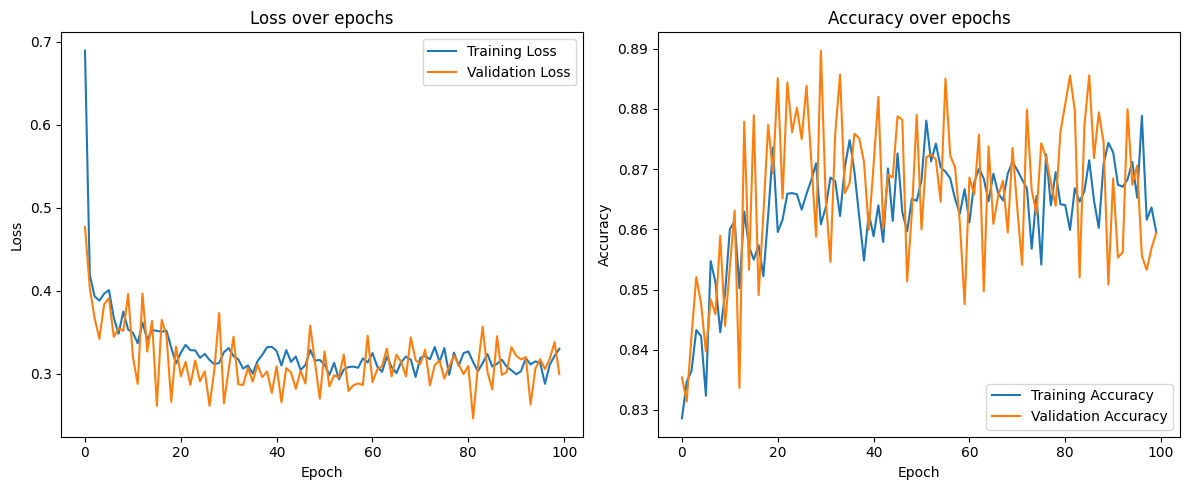


Final Evaluation on Test Set:


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 26.36it/s]


Classification Report:
              precision    recall  f1-score   support

     reserve       0.94      0.90      0.92       880
        wait       0.57      0.65      0.61       137
     reroute       0.44      0.68      0.54        28

    accuracy                           0.86      1045
   macro avg       0.65      0.74      0.69      1045
weighted avg       0.88      0.86      0.87      1045

Test Loss: 0.3036 | Test Accuracy: 0.8632

Running example inference...
Total robots: 5 | Red (request) messages: 5

Robot Summaries:
AGV-000: current node C4. target node C4. task priority low. timedelay 1.88 sec. signal red. waitNodeId []. alternate path [].
AGV-001: current node C6. target node C3. task priority low. timedelay 3.88 sec. signal red. waitNodeId []. alternate path ['C1'].
AGV-002: current node C3. target node C1. task priority low. timedelay 2.76 sec. signal red. waitNodeId []. alternate path ['C3'].
AGV-003: current node C1. target node C7. task priority medium. timedela

In [132]:


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GATConv, global_add_pool
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import random
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

class FleetDecisionDataset(Dataset):
    """Dataset class with reliable label generation"""
    def __init__(self, num_samples=1000, min_robots=1, max_robots=20):
        self.num_samples = num_samples
        self.min_robots = min_robots
        self.max_robots = max_robots
        self.simulator = SyntheticFleetSimulator(num_nodes=100)
        self.action_to_idx = {v:k for k,v in ACTION_NAMES.items()}
        self.idx_to_action = ACTION_NAMES

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        num_robots = random.randint(self.min_robots, self.max_robots)
        batch = self.simulator.generate_batch(num_robots)
        decisions = self.simulator.get_decisions(batch)
        return self.messages_to_graph(batch, decisions)

    def messages_to_graph(self, messages, decisions):
        node_features = []
        edge_index = []
        edge_attr = []
        targets = []
        node_types = []
        node_mapping = {}

        for i, msg in enumerate(messages):
            data = msg["data"]
            tp = data["trafficPathUpdates"]
            node_mapping[data["agentId"]] = i

            priority = data["taskStatus"]["priority"]
            time_delay = tp["timeDelay"]
            has_wait_node = 1 if tp["waitNodeId"] else 0
            has_alternate_path = 1 if tp["alternatePaths"] else 0
            pos = data["currentPosition"]

            features = [
                priority / 10.0,
                time_delay / 5.0,
                has_wait_node,
                has_alternate_path,
                pos["x"] / 100.0,
                pos["y"] / 100.0,
                pos["theta"] / 360.0
            ]

            node_features.append(features)
            node_types.append(0 if tp["signalLightStatus"] == "green" else 1)

        for i, msg1 in enumerate(messages):
            for j, msg2 in enumerate(messages):
                if i == j:
                    continue

                tp1 = msg1["data"]["trafficPathUpdates"]
                tp2 = msg2["data"]["trafficPathUpdates"]

                if (tp1["nextNodeId"] == tp2["reservedNode"] or
                    tp2["nextNodeId"] == tp1["reservedNode"]):
                    edge_index.append([i, j])
                    is_reciprocal = int(tp1["nextNodeId"] == tp2["reservedNode"] and
                                       tp2["nextNodeId"] == tp1["reservedNode"])
                    is_conflict = 1 if is_reciprocal or (tp1["nextNodeId"] == tp2["reservedNode"]) else 0
                    edge_attr.append([is_reciprocal, is_conflict])

        node_features = torch.tensor(node_features, dtype=torch.float)
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous() if edge_index else torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.tensor(edge_attr, dtype=torch.float) if edge_attr else torch.empty((0, 2), dtype=torch.float)
        node_types = torch.tensor(node_types, dtype=torch.long)

        target_indices = []
        target_values = []
        for i, msg in enumerate(messages):
            agent_id = msg["data"]["agentId"]
            if msg["data"]["trafficPathUpdates"]["signalLightStatus"] == "red":
                decision = decisions.get(agent_id, "wait")
                target_indices.append(i)
                target_values.append(self.action_to_idx[decision])

        targets = torch.full((len(messages),), -1, dtype=torch.long)
        if target_indices:
            targets[target_indices] = torch.tensor(target_values, dtype=torch.long)

        return Data(
            x=node_features,
            edge_index=edge_index,
            edge_attr=edge_attr,
            y=targets,
            node_types=node_types,
            num_red=sum(1 for t in node_types if t == 1),
            agent_ids=[msg["data"]["agentId"] for msg in messages]
        )

class SimpleGNN(nn.Module):
    """Simplified GNN without batch normalization"""
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads=4):
        super().__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=num_heads)
        self.conv2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads)
        self.conv3 = GATConv(hidden_dim * num_heads, output_dim, heads=1)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, edge_index, edge_attr, node_mask):
        x_masked = x[node_mask]

        if edge_index.size(1) > 0:
            orig_to_masked = torch.zeros(x.size(0), dtype=torch.long, device=x.device)
            orig_to_masked[node_mask] = torch.arange(node_mask.sum(), device=x.device)
            mask = node_mask[edge_index[0]] & node_mask[edge_index[1]]
            edge_index_masked = orig_to_masked[edge_index[:, mask]]
            edge_attr_masked = edge_attr[mask] if edge_attr.size(0) > 0 else edge_attr
        else:
            edge_index_masked = edge_index
            edge_attr_masked = edge_attr

        x_masked = F.leaky_relu(self.conv1(x_masked, edge_index_masked, edge_attr=edge_attr_masked))
        x_masked = self.dropout(x_masked)
        x_masked = F.leaky_relu(self.conv2(x_masked, edge_index_masked, edge_attr=edge_attr_masked))
        x_masked = self.dropout(x_masked)
        x_masked = self.conv3(x_masked, edge_index_masked, edge_attr=edge_attr_masked)

        x_out = torch.zeros(x.size(0), x_masked.size(1), device=x.device)
        x_out[node_mask] = x_masked
        return x_out

class FleetDecisionModel(nn.Module):
    """Complete model without batch normalization"""
    def __init__(self, input_dim=7, gnn_hidden=64, transformer_hidden=128,
                 num_actions=5, num_heads=4, dropout=0.1):
        super().__init__()

        self.green_head = SimpleGNN(input_dim, gnn_hidden, transformer_hidden//2, num_heads)
        self.red_head = SimpleGNN(input_dim, gnn_hidden, transformer_hidden//2, num_heads)

        # Simplified transformer - using a simple feedforward instead
        self.ff = nn.Sequential(
            nn.Linear(transformer_hidden, transformer_hidden),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(transformer_hidden, transformer_hidden),
            nn.LeakyReLU()
        )

        # Output head
        self.output_gnn1 = GATConv(transformer_hidden, gnn_hidden, heads=num_heads)
        self.output_gnn2 = GATConv(gnn_hidden * num_heads, gnn_hidden, heads=num_heads)
        self.output_gnn3 = GATConv(gnn_hidden * num_heads, num_actions, heads=1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, data):
        x, edge_index, edge_attr, node_types = data.x, data.edge_index, data.edge_attr, data.node_types

        green_mask = node_types == 0
        red_mask = node_types == 1
        all_mask = green_mask | red_mask

        green_features = self.green_head(x, edge_index, edge_attr, green_mask)
        red_features = self.red_head(x, edge_index, edge_attr, red_mask)
        combined_features = torch.cat([green_features, red_features], dim=1)

        # Simplified transformation instead of full transformer
        transformed = self.ff(combined_features)

        # Output GNN
        out = F.leaky_relu(self.output_gnn1(transformed, edge_index, edge_attr=edge_attr))
        out = self.dropout(out)
        out = F.leaky_relu(self.output_gnn2(out, edge_index, edge_attr=edge_attr))
        out = self.dropout(out)
        out = self.output_gnn3(out, edge_index, edge_attr=edge_attr)

        return out

def collate_fn(batch):
    """Proper graph batching using PyG's Batch"""
    return Batch.from_data_list(batch)

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total_red = 0

    for data in tqdm(dataloader, desc="Training"):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)

        red_mask = data.node_types == 1
        preds = out[red_mask]
        targets = data.y[red_mask]

        if preds.size(0) == 0:
            continue

        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(preds, 1)
        correct += (predicted == targets).sum().item()
        total_red += targets.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total_red if total_red > 0 else 0
    return avg_loss, accuracy


def evaluate(model, dataloader, criterion, device, print_report=False):
    model.eval()
    total_loss = 0
    correct = 0
    total_red = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data in tqdm(dataloader, desc="Evaluating"):
            data = data.to(device)
            out = model(data)

            red_mask = data.node_types == 1
            preds = out[red_mask]
            targets = data.y[red_mask]

            if preds.size(0) == 0:
                continue

            loss = criterion(preds, targets)
            total_loss += loss.item()
            _, predicted = torch.max(preds, 1)
            correct += (predicted == targets).sum().item()
            total_red += targets.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total_red if total_red > 0 else 0

    if print_report and total_red > 0:
        print("\nClassification Report:")
        # Get the unique classes present in the data
        present_classes = set(all_targets)
        # Filter target names to only include present classes
        filtered_target_names = [ACTION_NAMES[i] for i in sorted(present_classes)]
        # Convert to list to maintain order
        labels = sorted(present_classes)

        print(classification_report(
            all_targets,
            all_preds,
            labels=labels,
            target_names=filtered_target_names,
            zero_division=0
        ))

    return avg_loss, accuracy

def plot_training(loss_history, val_loss_history, accuracy_history, val_accuracy_history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(loss_history, label='Training Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracy_history, label='Training Accuracy')
    plt.plot(val_accuracy_history, label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    device = 'cpu' # torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Hyperparameters
    batch_size = 32
    num_epochs = 100
    learning_rate = 0.001
    train_size = 1000
    val_size = 200
    test_size = 200

    # Create datasets and dataloaders
    train_dataset = FleetDecisionDataset(num_samples=train_size)
    val_dataset = FleetDecisionDataset(num_samples=val_size)
    test_dataset = FleetDecisionDataset(num_samples=test_size)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # Initialize model
    model = FleetDecisionModel().to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss(ignore_index=-1)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    # Training loop
    best_val_loss = float('inf')
    loss_history = []
    val_loss_history = []
    accuracy_history = []
    val_accuracy_history = []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        accuracy_history.append(train_acc)
        val_accuracy_history.append(val_acc)

        if (epoch + 1) % 5 == 0:  # Print every 10 epochs
            print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
            print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

    plot_training(loss_history, val_loss_history, accuracy_history, val_accuracy_history)

    # Final evaluation
    print("\nFinal Evaluation on Test Set:")
    test_loss, test_acc = evaluate(model, test_loader, criterion, device, print_report=True)
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")


    # Example inference
    print("\nRunning example inference...")
    simulator = SyntheticFleetSimulator(num_nodes=9)
    batch = simulator.generate_batch(5)

    # Print input data
    red_count = sum(1 for msg in batch if msg["data"]["trafficPathUpdates"]["signalLightStatus"] == "red")
    print(f"Total robots: {len(batch)} | Red (request) messages: {red_count}\n")

    print("Robot Summaries:")
    for msg in batch:
        data = msg["data"]
        agent = data["agentId"]
        current_node = data["trafficPathUpdates"]["reservedNode"]
        target_node = data["trafficPathUpdates"]["nextNodeId"]
        priority = data["taskStatus"]["priority"]
        prio_str = priority_to_str(priority)
        time_delay = data["trafficPathUpdates"]["timeDelay"]
        signal = data["trafficPathUpdates"]["signalLightStatus"]
        wait_nodes = data["trafficPathUpdates"]["waitNodeId"]
        alt_paths = data["trafficPathUpdates"]["alternatePaths"]
        print(f"{agent}: current node {current_node}. target node {target_node}. "
              f"task priority {prio_str}. timedelay {time_delay} sec. signal {signal}. "
              f"waitNodeId {wait_nodes}. alternate path {alt_paths}.")

    # Get ground truth decisions
    decisions = simulator.get_decisions(batch)
    print("\nSupervised Targets (agentId: decision):")
    for agent, decision in decisions.items():
        print(f"{agent}: {decision}")

    # Convert to graph and run inference
    graph_data = train_dataset.messages_to_graph(batch, decisions)
    graph_data = graph_data.to(device)

    model.eval()
    with torch.no_grad():
        out = model(graph_data)

        red_mask = graph_data.node_types == 1
        preds = out[red_mask]
        _, predicted = torch.max(preds, 1)

        red_agent_ids = [graph_data.agent_ids[i] for i in range(len(graph_data.agent_ids)) if red_mask[i]]

        print("\nModel Predictions:")
        for agent_id, pred_idx in zip(red_agent_ids, predicted):
            print(f"{agent_id}: {ACTION_NAMES[pred_idx.item()]}")

if __name__ == "__main__":
    main()

Using device: cpu
Epoch 5:
  Train Loss: 0.6388 | Train Acc: 0.8182
  Val Loss: 0.4467 | Val Acc: 0.8750
Epoch 10:
  Train Loss: 0.4456 | Train Acc: 0.9024
  Val Loss: 0.4614 | Val Acc: 0.8400
Epoch 00011: reducing learning rate of group 0 to 5.0000e-03.
Epoch 15:
  Train Loss: 0.6135 | Train Acc: 0.7815
  Val Loss: 0.3765 | Val Acc: 0.9130
Epoch 00018: reducing learning rate of group 0 to 2.5000e-03.
Epoch 20:
  Train Loss: 0.5338 | Train Acc: 0.8467
  Val Loss: 0.6226 | Val Acc: 0.8261
Epoch 00022: reducing learning rate of group 0 to 1.2500e-03.
Epoch 25:
  Train Loss: 0.5830 | Train Acc: 0.8448
  Val Loss: 0.5233 | Val Acc: 0.7407
Epoch 00026: reducing learning rate of group 0 to 6.2500e-04.
Epoch 30:
  Train Loss: 0.4162 | Train Acc: 0.8702
  Val Loss: 0.5138 | Val Acc: 0.8387
Epoch 00033: reducing learning rate of group 0 to 3.1250e-04.
Epoch 35:
  Train Loss: 0.4582 | Train Acc: 0.8684
  Val Loss: 0.2611 | Val Acc: 0.9615
Epoch 00037: reducing learning rate of group 0 to 1.5625e

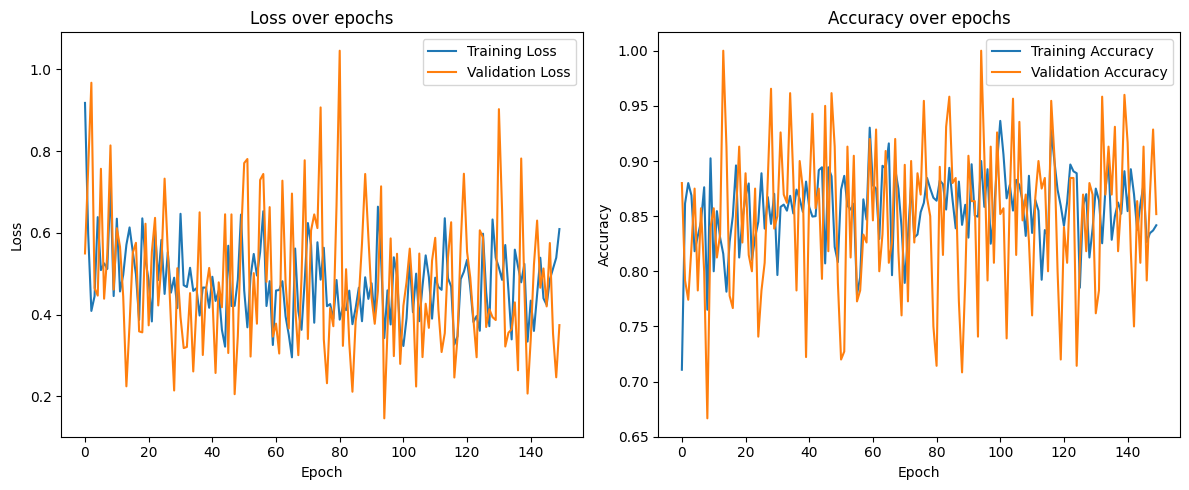


Classification Report:
              precision    recall  f1-score   support

     reserve       0.79      1.00      0.88        11
        wait       0.00      0.00      0.00         3

    accuracy                           0.79        14
   macro avg       0.39      0.50      0.44        14
weighted avg       0.62      0.79      0.69        14

Test Loss 0.5251, Test Accuracy 0.7857

Running example inference...
Total robots: 5 | Red (request) messages: 3

Robot Summaries:
AGV-000: current node C3. target node C3. task priority low. timedelay 1.53 sec. signal red. waitNodeId []. alternate path [].
AGV-001: current node C4. target node C2. task priority high. timedelay 4.94 sec. signal red. waitNodeId []. alternate path [].
AGV-002: current node C6. target node C9. task priority medium. timedelay 4.13 sec. signal green. waitNodeId []. alternate path ['C4'].
AGV-003: current node C1. target node C7. task priority medium. timedelay 3.77 sec. signal red. waitNodeId ['W1']. alternate pa

In [144]:
import random
from typing import Any, Dict, List
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report  # for detailed evaluation

# Global constants
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EMBED_DIM = 16  # change to 32 if desired

# Action names for easier interpretation.
ACTION_NAMES = {0: "reserve", 1: "yield", 2: "wait", 3: "reroute", 4: "pause"}

def priority_to_str(priority: int) -> str:
    if priority <= 3:
        return "low"
    elif priority <= 7:
        return "medium"
    else:
        return "high"

# =============================================================================
# SIMULATOR
# =============================================================================

class SyntheticFleetSimulator:
    """
    Simulator for generating a complete run (instance) of a fleet of robots.
    """
    def __init__(self, num_nodes: int = 50):
        self.node_pool = [f"C{i}" for i in range(1, num_nodes + 1)]
        self.waitpoint_map = {node: f"W{node[1:]}" for node in self.node_pool}
        self.node_types = ["checkpoint", "charge_dock", "home_dock", "station_dock", "elevator", "door"]

    def random_node(self) -> str:
        return random.choice(self.node_pool)

    def get_wait_node(self, node: str, signal: str) -> List[str]:
        node_type = random.choice(self.node_types)
        if node_type == "checkpoint" and signal == "red" and random.random() < 0.5:
            return [self.waitpoint_map[node]]
        return []

    def get_alternate_route(self) -> List[str]:
        if random.random() < 0.5:
            return [random.choice(self.node_pool)]
        return []

    def generate_message(self, agent_id: str, signal: str, reserved_node: str) -> Dict[str, Any]:
        next_node = self.random_node()
        time_delay = round(random.uniform(0.1, 5.0), 2)
        priority = random.randint(1, 10)
        alternate_paths = self.get_alternate_route()
        wait_node = self.get_wait_node(reserved_node, signal)
        message = {
            "type": "common",
            "timestamp": "2024-12-02T10:15:00Z",
            "headerId": f"unique-message-id-{agent_id}",
            "zoneId": "fleet_1",
            "data": {
                "agentId": agent_id,
                "currentPosition": {
                    "x": round(random.uniform(0, 100), 2),
                    "y": round(random.uniform(0, 100), 2),
                    "theta": round(random.uniform(0, 360), 2)
                },
                "batteryLevel": random.randint(20, 100),
                "agentStatus": "online",
                "errorCodes": [],
                "taskStatus": {
                    "taskId": f"task_{random.randint(100,999)}",
                    "createdAt": "2019-08-24T14:15:22Z",
                    "executedAt": "2019-08-24T14:15:22Z",
                    "progress": random.randint(0, 100),
                    "priority": priority,
                    "loadCapacityKg": random.randint(5, 20),
                    "estimatedCompletionTime": "2024-11-20T14:30:00Z",
                    "taskBidUtilityValue": round(random.uniform(0.5, 1.0), 2),
                    "completedTaskHistory": [f"task_{random.randint(100,999)}" for _ in range(4)]
                },
                "trafficPathUpdates": {
                    "reservedNode": reserved_node,
                    "nextNodeId": next_node,
                    "waitNodeId": wait_node,
                    "timeDelay": time_delay,
                    "alternatePaths": alternate_paths,
                    "signalLightStatus": signal
                },
                "plantResourceStatus": [
                    {"resourceType": "door", "resourceId": "door_01", "action_request": "open"},
                    {"resourceType": "elevator", "resourceId": "elevator_03", "action_request": "call"},
                    {"resourceType": "conveyor", "resourceId": "conveyor_02", "action_request": "call"}
                ]
            }
        }
        return message

    def generate_batch(self, num_robots: int) -> List[Dict[str, Any]]:
        """
        Generate a complete simulation run (instance) with a fixed number of robots.
        """
        batch = []
        if num_robots > len(self.node_pool):
            raise ValueError("Number of robots cannot exceed the number of nodes for unique reserved nodes.")
        reserved_nodes = random.sample(self.node_pool, k=num_robots)
        for i in range(num_robots):
            signal = random.choice(["green", "red"])
            msg = self.generate_message(f"AGV-{i:03d}", signal, reserved_nodes[i])
            batch.append(msg)
        return batch

    # v3
    def get_decisions(self, batch: List[Dict[str, Any]]) -> Dict[str, str]:
        """
        Process the batch of messages and return a dict mapping each red robot's agentId
        to its decision. This upgraded function scales beyond 3 robots by using a global
        ordering of red (request) robots based on effective priority (priority level and waiting time)
        and sequentially “locking” target nodes. It then builds a conflict graph and resolves any conflicts
        (both non-mutual conflicts and direct stand-offs) iteratively until decisions stabilize.

        Decisions:
        - "reserve": robot is granted its target (or alternate) node.
        - "wait": robot must wait at its current position.
        - "reroute": robot will take an alternate route.
        - "yield": in a stand-off conflict, the robot that must back down.
        - "pause": both robots in a stand-off have no alternatives, triggering human help.

        Edge Case:
        - If a red robot's current node equals its target node, it is already at its desired position,
            so it is immediately given a "reserve" decision.
        """
        # Map string priorities to numeric values for comparison.
        prio_map = {"low": 1, "medium": 2, "high": 3}

        # ----------------------------
        # Step 0: Preprocess robots
        # ----------------------------
        # Build a simplified list of robot dictionaries.
        robots = []
        for msg in batch:
            data = msg["data"]
            tp = data["trafficPathUpdates"]
            robot = {
                "name": data["agentId"],
                "current": tp["reservedNode"],
                "target": tp["nextNodeId"],
                "priority": priority_to_str(data["taskStatus"]["priority"]),
                "time_delay": tp["timeDelay"],
                "signal": tp["signalLightStatus"],
                "wait": tp["waitNodeId"],       # List of wait nodes (if any)
                "alt": tp["alternatePaths"]      # List of alternate paths (if any)
            }
            robots.append(robot)

        # Separate red (waiting for decision) robots from green (in motion).
        red = [r for r in robots if r["signal"] == "red"]
        green = [r for r in robots if r["signal"] == "green"]

        decisions = {}      # Final mapping: agentId -> decision.
        locked_nodes = {}   # Map of node -> agentId that has locked that node.

        # Build a set of nodes already reserved (occupied) by green robots.
        green_reserved = {g["current"] for g in green}

        # ----------------------------
        # Step 1: Sequential Locking via Global Sorting
        # ----------------------------
        # Compute effective priority for red robots: (numeric priority, time_delay).
        # Higher numeric value and longer waiting time are better.
        red_sorted = sorted(red, key=lambda r: (prio_map[r["priority"]], r["time_delay"]), reverse=True)

        # Define a threshold for considering alternate paths.
        threshold = 0.5

        # Process each red robot (best effective priority first)
        for r in red_sorted:
            # Edge case: if the robot is already at its target node,
            # simply grant it "reserve" and lock that node.
            if r["current"] == r["target"]:
                decisions[r["name"]] = "reserve"
                locked_nodes[r["target"]] = r["name"]
                continue

            # Otherwise, try to lock the desired target if it's not already taken.
            if r["target"] not in green_reserved and r["target"] not in locked_nodes:
                decisions[r["name"]] = "reserve"
                locked_nodes[r["target"]] = r["name"]
            else:
                decisions[r["name"]] = "wait"

            # Check if the robot qualifies for a reroute: if waiting beyond the threshold and has an alternate.
            if decisions[r["name"]] == "wait" and r["time_delay"] >= threshold and r["alt"]:
                free_alts = [alt for alt in r["alt"] if alt not in green_reserved and alt not in locked_nodes]
                if free_alts:
                    decisions[r["name"]] = "reroute"
                    locked_nodes[free_alts[0]] = r["name"]

        # ----------------------------
        # Step 2: Build and Resolve Conflict Graph
        # ----------------------------
        # We now resolve two types of conflicts:
        #   (a) Non-mutual conflicts: where a red robot's target equals another red robot's current node,
        #       but that other robot is not switching back.
        #   (b) Direct stand-offs: two red robots with each other's current node as their target.
        # Iterate until no decision changes occur.
        changed = True
        while changed:
            changed = False

            # (a) Resolve conflicts among red robots competing for the same target.
            target_groups = {}
            for r in red:
                # Skip edge-case robots already at their target.
                if r["current"] == r["target"]:
                    continue
                if decisions[r["name"]] in ["reserve", "reroute"]:
                    target_groups.setdefault(r["target"], []).append(r)
            for target, group in target_groups.items():
                if len(group) > 1:
                    # Select the best candidate in the group.
                    best = max(group, key=lambda r: (prio_map[r["priority"]], r["time_delay"]))
                    for r in group:
                        if r["name"] != best["name"]:
                            if decisions[r["name"]] != "wait":
                                decisions[r["name"]] = "wait"
                                if target in locked_nodes and locked_nodes[target] == r["name"]:
                                    del locked_nodes[target]
                                changed = True

            # (b) Resolve non-mutual conflicts.
            for r in red:
                # Skip edge-case robots that already are at their target.
                if r["current"] == r["target"]:
                    continue
                for other in red:
                    if r["name"] == other["name"]:
                        continue
                    if r["target"] == other["current"] and other["target"] != r["current"]:
                        if decisions[r["name"]] != "wait":
                            decisions[r["name"]] = "wait"
                            if r["target"] in locked_nodes and locked_nodes[r["target"]] == r["name"]:
                                del locked_nodes[r["target"]]
                            changed = True

            # (c) Resolve direct stand-off conflicts.
            # Stand-off: r1.target == r2.current  and  r2.target == r1.current.
            for i in range(len(red)):
                for j in range(i + 1, len(red)):
                    r1 = red[i]
                    r2 = red[j]
                    # Skip if either is in the edge case (current equals target).
                    if r1["current"] == r1["target"] or r2["current"] == r2["target"]:
                        continue
                    if r1["target"] == r2["current"] and r2["target"] == r1["current"]:
                        eff1 = (prio_map[r1["priority"]], r1["time_delay"])
                        eff2 = (prio_map[r2["priority"]], r2["time_delay"])
                        if eff1 != eff2:
                            if eff1 > eff2:
                                superior, inferior = r1, r2
                            else:
                                superior, inferior = r2, r1
                            # If the inferior robot lacks both a wait node and an alternate...
                            if (not inferior["wait"]) and (not inferior["alt"]):
                                # Check if the superior robot also lacks alternatives.
                                if (not superior["wait"]) and (not superior["alt"]):
                                    # Neither can yield safely: assign "pause" to both.
                                    if decisions[superior["name"]] != "pause":
                                        decisions[superior["name"]] = "pause"
                                        if superior["target"] in locked_nodes and locked_nodes[superior["target"]] == superior["name"]:
                                            del locked_nodes[superior["target"]]
                                        changed = True
                                    if decisions[inferior["name"]] != "pause":
                                        decisions[inferior["name"]] = "pause"
                                        if inferior["target"] in locked_nodes and locked_nodes[inferior["target"]] == inferior["name"]:
                                            del locked_nodes[inferior["target"]]
                                        changed = True
                                else:
                                    # Superior has an alternative, so inferior must yield.
                                    if decisions[superior["name"]] != "yield":
                                        decisions[superior["name"]] = "yield"
                                        if superior["target"] in locked_nodes and locked_nodes[superior["target"]] == superior["name"]:
                                            del locked_nodes[superior["target"]]
                                        changed = True
                            else:
                                # Otherwise, assign "yield" to the inferior and "reserve" to the superior.
                                if decisions[inferior["name"]] != "yield":
                                    decisions[inferior["name"]] = "yield"
                                    if inferior["target"] in locked_nodes and locked_nodes[inferior["target"]] == inferior["name"]:
                                        del locked_nodes[inferior["target"]]
                                    changed = True
                                if decisions[superior["name"]] != "reserve":
                                    decisions[superior["name"]] = "reserve"
                                    if superior["target"] not in locked_nodes:
                                        locked_nodes[superior["target"]] = superior["name"]
                                    changed = True

        # ----------------------------
        # Final Step: Return decisions for all red robots.
        # (Green robots are assumed to be in motion and do not require decisions.)
        return decisions


# =============================================================================
# DATA PROCESSING (Duplicate for convenience – can remove if using one instance)
# =============================================================================

class DataProcessor:
    def __init__(self, embed_dim: int = EMBED_DIM):
        self.embed_dim = embed_dim
        self.node_vocab = {f"node_{i}": i - 1 for i in range(1, 6)}
        self.num_nodes = len(self.node_vocab)
        self.node_embedding = nn.Embedding(self.num_nodes, 8).to(DEVICE)

    def encode_node(self, node: str) -> torch.Tensor:
        idx = self.node_vocab.get(node, 0)
        return self.node_embedding(torch.tensor(idx, device=DEVICE))

    def process_message(self, message: Dict[str, Any]) -> torch.Tensor:
        data = message["data"]
        pos = data["currentPosition"]
        task = data["taskStatus"]
        traffic = data["trafficPathUpdates"]
        features = []
        features.append(float(pos["x"]) / 100.0)
        features.append(float(pos["y"]) / 100.0)
        features.append(float(pos["theta"]) / 360.0)
        features.append(float(data["batteryLevel"]) / 100.0)
        features.append(float(task["progress"]) / 100.0)
        features.append(float(task["priority"]) / 10.0)
        features.append(float(traffic["timeDelay"]) / 2.0)
        next_node_emb = self.encode_node(traffic["nextNodeId"]).squeeze().tolist()
        features.extend(next_node_emb)
        reserved_node_emb = self.encode_node(traffic["reservedNode"]).squeeze().tolist()
        features.extend(reserved_node_emb)
        if len(features) < self.embed_dim:
            features += [0.0] * (self.embed_dim - len(features))
        else:
            features = features[:self.embed_dim]
        return torch.tensor(features, dtype=torch.float32)

    def process_batch(self, messages: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        op_features = []
        req_features = []
        req_agent_ids = []
        for msg in messages:
            tensor = self.process_message(msg)
            signal = msg["data"]["trafficPathUpdates"]["signalLightStatus"]
            if signal == "green":
                op_features.append(tensor)
            else:
                req_features.append(tensor)
                req_agent_ids.append(msg["data"]["agentId"])
        op_tensor = torch.stack(op_features) if op_features else torch.empty(0, self.embed_dim)
        req_tensor = torch.stack(req_features) if req_features else torch.empty(0, self.embed_dim)
        return {"operation": op_tensor.to(DEVICE), "request": req_tensor.to(DEVICE), "agent_ids": req_agent_ids}

# =============================================================================
# GRAPH NETWORK CONSTRUCTION (BASIC GNN LAYER)
# =============================================================================

class GraphNetwork(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super(GraphNetwork, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, X: torch.Tensor, A: torch.Tensor) -> torch.Tensor:
        h = self.linear(X)
        h = torch.matmul(A, h)
        return F.relu(h)

def create_adjacency_matrix(num_nodes: int) -> torch.Tensor:
    if num_nodes == 0:
        return torch.empty(0, 0, device=DEVICE)
    A = torch.ones(num_nodes, num_nodes, device=DEVICE)
    D = A.sum(dim=1, keepdim=True)
    return A / D

# =============================================================================
# DUAL GNN DECISION NETWORK
# =============================================================================

class DualGNNDecisionNetwork(nn.Module):
    """
    A dual-head GNN model where:
      - The request head processes waiting (red) robot features.
      - The operation head processes in-motion (green) robot features.
    A simple cross-attention mechanism aggregates operation context for each request.
    Finally, each request node is classified into one of the decision actions.
    """
    def __init__(self, input_dim: int = EMBED_DIM, hidden_dim: int = 64, num_classes: int = 5):
        super(DualGNNDecisionNetwork, self).__init__()
        self.request_gnn = GraphNetwork(input_dim, hidden_dim)
        self.operation_gnn = GraphNetwork(input_dim, hidden_dim)
        self.W_q = nn.Linear(hidden_dim, hidden_dim)
        self.W_k = nn.Linear(hidden_dim, hidden_dim)
        self.W_v = nn.Linear(hidden_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, req_features: torch.Tensor, op_features: torch.Tensor) -> torch.Tensor:
        A_req = create_adjacency_matrix(req_features.size(0))
        H_req = self.request_gnn(req_features, A_req)
        if op_features.size(0) > 0:
            A_op = create_adjacency_matrix(op_features.size(0))
            H_op = self.operation_gnn(op_features, A_op)
        else:
            H_op = None
        Q = self.W_q(H_req)
        if H_op is not None:
            K = self.W_k(H_op)
            V = self.W_v(H_op)
            scores = torch.matmul(Q, K.transpose(0, 1)) / np.sqrt(H_req.size(1))
            attn_weights = F.softmax(scores, dim=1)
            context = torch.matmul(attn_weights, V)
        else:
            context = torch.zeros_like(Q)
        combined = torch.cat([H_req, context], dim=1)
        logits = self.classifier(combined)
        return logits

# =============================================================================
# SUPERVISED DATASET FOR DECISION NETWORK
# =============================================================================

label_map = {"reserve": 0, "yield": 1, "wait": 2, "reroute": 3, "pause": 4}

class FleetDecisionDataset(Dataset):
    """
    Each dataset item is one full simulation run (instance) with a complete set of robots.
    """
    def __init__(self, num_samples: int, num_robots: int = 10):
        self.num_samples = num_samples
        self.num_robots = num_robots
        self.simulator = SyntheticFleetSimulator(num_nodes=50)
        self.processor = DataProcessor(embed_dim=EMBED_DIM)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Generate one complete instance (simulation run)
        messages = self.simulator.generate_batch(self.num_robots)
        processed = self.processor.process_batch(messages)
        decisions = self.simulator.get_decisions(messages)
        labels = []
        for agent in processed["agent_ids"]:
            decision = decisions.get(agent, "wait")
            labels.append(label_map[decision])
        labels_tensor = torch.tensor(labels, dtype=torch.long, device=DEVICE)
        return {"operation": processed["operation"],
                "request": processed["request"],
                "labels": labels_tensor}

def collate_fn(batch):
    # Since each dataset item is a complete instance, we simply return the item.
    return batch[0]

# =============================================================================
# TRAINING AND EVALUATION FUNCTIONS
# =============================================================================

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for instance in dataloader:  # each instance is a complete run
        op_features = instance["operation"]
        req_features = instance["request"]
        labels = instance["labels"]
        if req_features.shape[0] == 0:
            continue
        optimizer.zero_grad()
        logits = model(req_features, op_features)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    epoch_loss = running_loss / len(dataloader)
    accuracy = correct / total if total > 0 else 0
    return epoch_loss, accuracy

def evaluate(model, dataloader, criterion, device, print_report=False):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for instance in dataloader:
            op_features = instance["operation"]
            req_features = instance["request"]
            labels = instance["labels"]
            if req_features.shape[0] == 0:
                continue
            logits = model(req_features, op_features)
            loss = criterion(logits, labels)
            running_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
    epoch_loss = running_loss / len(dataloader)
    accuracy = correct / total if total > 0 else 0

    if print_report and total > 0:
        print("\nClassification Report:")
        present_classes = set(all_targets)
        filtered_target_names = [ACTION_NAMES[i] for i in sorted(present_classes)]
        labels_order = sorted(present_classes)
        print(classification_report(all_targets, all_preds, labels=labels_order,
                                    target_names=filtered_target_names, zero_division=0))
    return epoch_loss, accuracy

def plot_training(loss_history, val_loss_history, accuracy_history, val_accuracy_history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(loss_history, label='Training Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(accuracy_history, label='Training Accuracy')
    plt.plot(val_accuracy_history, label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN FUNCTION
# =============================================================================

def main():
    print(f"Using device: {DEVICE}")
    num_epochs = 150
    learning_rate = 0.01
    train_size = 35
    val_size = 7
    test_size = 5
    num_robots_per_instance = 7  # Each instance is a full run with 10 robots

    # Set batch_size = 1 so that each batch corresponds to one full simulation run
    train_dataset = FleetDecisionDataset(num_samples=train_size, num_robots=num_robots_per_instance)
    val_dataset = FleetDecisionDataset(num_samples=val_size, num_robots=num_robots_per_instance)
    test_dataset = FleetDecisionDataset(num_samples=test_size, num_robots=num_robots_per_instance)

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

    model = DualGNNDecisionNetwork(input_dim=EMBED_DIM, hidden_dim=64, num_classes=5).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                           factor=0.5, patience=3, verbose=True)
    best_val_loss = float('inf')

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, DEVICE)
        val_loss, val_acc = evaluate(model, val_loader, criterion, DEVICE)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)
        if epoch % 5 == 0:
            print(f"Epoch {epoch}:")
            print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
            print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

    plot_training(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
    test_loss, test_acc = evaluate(model, test_loader, criterion, DEVICE, print_report=True)
    print(f"Test Loss {test_loss:.4f}, Test Accuracy {test_acc:.4f}")

    # -------------------------------
    # Example inference on a simulated batch (full instance)
    # -------------------------------
    print("\nRunning example inference...")
    simulator = SyntheticFleetSimulator(num_nodes=9)
    batch = simulator.generate_batch(5)  # Generate one simulation run with 5 robots

    red_count = sum(1 for msg in batch if msg["data"]["trafficPathUpdates"]["signalLightStatus"] == "red")
    print(f"Total robots: {len(batch)} | Red (request) messages: {red_count}\n")

    print("Robot Summaries:")
    for msg in batch:
        data = msg["data"]
        agent = data["agentId"]
        current_node = data["trafficPathUpdates"]["reservedNode"]
        target_node = data["trafficPathUpdates"]["nextNodeId"]
        priority = data["taskStatus"]["priority"]
        prio_str = priority_to_str(priority)
        time_delay = data["trafficPathUpdates"]["timeDelay"]
        signal = data["trafficPathUpdates"]["signalLightStatus"]
        wait_nodes = data["trafficPathUpdates"]["waitNodeId"]
        alt_paths = data["trafficPathUpdates"]["alternatePaths"]
        print(f"{agent}: current node {current_node}. target node {target_node}. "
              f"task priority {prio_str}. timedelay {time_delay} sec. signal {signal}. "
              f"waitNodeId {wait_nodes}. alternate path {alt_paths}.")

    decisions = simulator.get_decisions(batch)
    print("\nSupervised Targets (agentId: decision):")
    for agent, decision in decisions.items():
        print(f"{agent}: {decision}")

    processor = DataProcessor(embed_dim=EMBED_DIM)
    data_dict = processor.process_batch(batch)
    req_features = data_dict["request"]
    op_features = data_dict["operation"]
    agent_ids = data_dict["agent_ids"]

    model.eval()
    with torch.no_grad():
        logits = model(req_features, op_features)
        _, predicted = torch.max(logits, 1)

    print("\nModel Predictions:")
    for agent_id, pred_idx in zip(agent_ids, predicted):
        print(f"{agent_id}: {ACTION_NAMES[pred_idx.item()]}")

if __name__ == "__main__":
    main()


Using device: cpu
Epoch 5:
  Train Loss: 1.4255 | Train Acc: 0.8197
  Val Loss: 1.3472 | Val Acc: 1.0000
Epoch 10:
  Train Loss: 1.1929 | Train Acc: 0.8932
  Val Loss: 1.1927 | Val Acc: 0.8947
Epoch 15:
  Train Loss: 1.0465 | Train Acc: 0.9077
  Val Loss: 1.1241 | Val Acc: 0.8182
Epoch 00017: reducing learning rate of group 0 to 5.0000e-05.
Epoch 20:
  Train Loss: 1.1557 | Train Acc: 0.8030
  Val Loss: 0.9583 | Val Acc: 0.9167
Epoch 00021: reducing learning rate of group 0 to 2.5000e-05.
Epoch 25:
  Train Loss: 1.0330 | Train Acc: 0.8374
  Val Loss: 1.0462 | Val Acc: 0.8095
Epoch 00025: reducing learning rate of group 0 to 1.2500e-05.
Epoch 00029: reducing learning rate of group 0 to 6.2500e-06.
Epoch 30:
  Train Loss: 0.9755 | Train Acc: 0.8261
  Val Loss: 0.8790 | Val Acc: 0.8889
Epoch 00033: reducing learning rate of group 0 to 3.1250e-06.
Epoch 35:
  Train Loss: 0.9733 | Train Acc: 0.8618
  Val Loss: 1.0457 | Val Acc: 0.7600
Epoch 00038: reducing learning rate of group 0 to 1.5625e

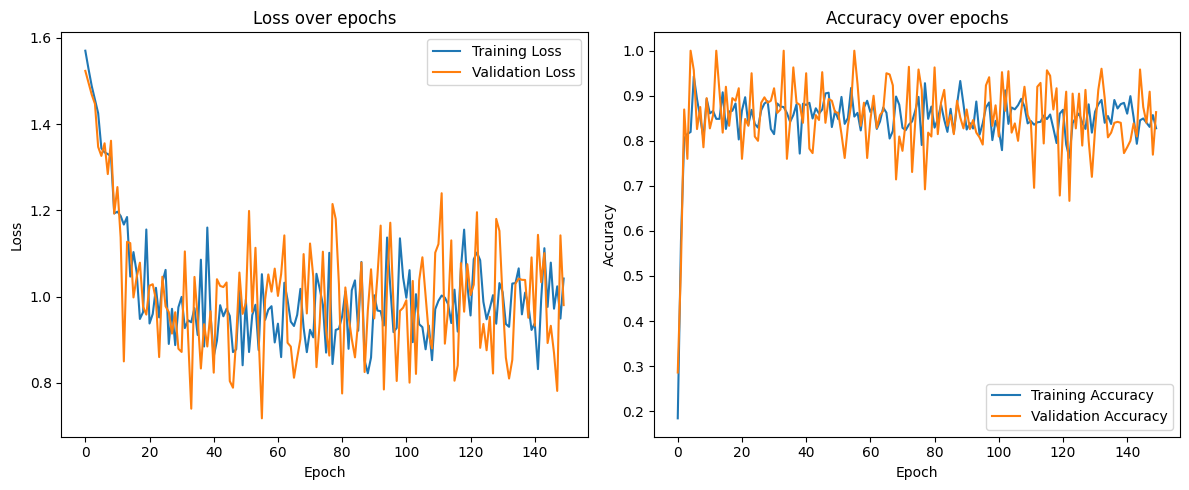


Classification Report:
              precision    recall  f1-score   support

     reserve       0.88      1.00      0.93        14
        wait       0.00      0.00      0.00         2

    accuracy                           0.88        16
   macro avg       0.44      0.50      0.47        16
weighted avg       0.77      0.88      0.82        16

Test Loss 0.8106, Test Accuracy 0.8750

Running example inference...
Total robots: 5 | Red (request) messages: 3

Robot Summaries:
AGV-000: current node C6. target node C6. task priority high. timedelay 1.01 sec. signal red. waitNodeId []. alternate path [].
AGV-001: current node C9. target node C2. task priority medium. timedelay 0.67 sec. signal red. waitNodeId []. alternate path ['C8'].
AGV-002: current node C4. target node C8. task priority medium. timedelay 2.99 sec. signal green. waitNodeId []. alternate path [].
AGV-003: current node C7. target node C4. task priority medium. timedelay 3.98 sec. signal green. waitNodeId []. alternate p

In [152]:
import random
from typing import Any, Dict, List
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report  # for detailed evaluation

# Global constants
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EMBED_DIM = 8  # or increase to 32 if desired

# Action names for easier interpretation.
ACTION_NAMES = {0: "reserve", 1: "yield", 2: "wait", 3: "reroute", 4: "pause"}

def priority_to_str(priority: int) -> str:
    if priority <= 3:
        return "low"
    elif priority <= 7:
        return "medium"
    else:
        return "high"

# =============================================================================
# SIMULATOR
# =============================================================================

class SyntheticFleetSimulator:
    """
    Simulator for generating a complete run (instance) of a fleet of robots.
    """
    def __init__(self, num_nodes: int = 50):
        self.node_pool = [f"C{i}" for i in range(1, num_nodes + 1)]
        self.waitpoint_map = {node: f"W{node[1:]}" for node in self.node_pool}
        self.node_types = ["checkpoint", "charge_dock", "home_dock", "station_dock", "elevator", "door"]

    def random_node(self) -> str:
        return random.choice(self.node_pool)

    def get_wait_node(self, node: str, signal: str) -> List[str]:
        node_type = random.choice(self.node_types)
        if node_type == "checkpoint" and signal == "red" and random.random() < 0.5:
            return [self.waitpoint_map[node]]
        return []

    def get_alternate_route(self) -> List[str]:
        if random.random() < 0.5:
            return [random.choice(self.node_pool)]
        return []

    def generate_message(self, agent_id: str, signal: str, reserved_node: str) -> Dict[str, Any]:
        next_node = self.random_node()
        time_delay = round(random.uniform(0.1, 5.0), 2)
        priority = random.randint(1, 10)
        alternate_paths = self.get_alternate_route()
        wait_node = self.get_wait_node(reserved_node, signal)
        message = {
            "type": "common",
            "timestamp": "2024-12-02T10:15:00Z",
            "headerId": f"unique-message-id-{agent_id}",
            "zoneId": "fleet_1",
            "data": {
                "agentId": agent_id,
                "currentPosition": {
                    "x": round(random.uniform(0, 100), 2),
                    "y": round(random.uniform(0, 100), 2),
                    "theta": round(random.uniform(0, 360), 2)
                },
                "batteryLevel": random.randint(20, 100),
                "agentStatus": "online",
                "errorCodes": [],
                "taskStatus": {
                    "taskId": f"task_{random.randint(100,999)}",
                    "createdAt": "2019-08-24T14:15:22Z",
                    "executedAt": "2019-08-24T14:15:22Z",
                    "progress": random.randint(0, 100),
                    "priority": priority,
                    "loadCapacityKg": random.randint(5, 20),
                    "estimatedCompletionTime": "2024-11-20T14:30:00Z",
                    "taskBidUtilityValue": round(random.uniform(0.5, 1.0), 2),
                    "completedTaskHistory": [f"task_{random.randint(100,999)}" for _ in range(4)]
                },
                "trafficPathUpdates": {
                    "reservedNode": reserved_node,
                    "nextNodeId": next_node,
                    "waitNodeId": wait_node,
                    "timeDelay": time_delay,
                    "alternatePaths": alternate_paths,
                    "signalLightStatus": signal
                },
                "plantResourceStatus": [
                    {"resourceType": "door", "resourceId": "door_01", "action_request": "open"},
                    {"resourceType": "elevator", "resourceId": "elevator_03", "action_request": "call"},
                    {"resourceType": "conveyor", "resourceId": "conveyor_02", "action_request": "call"}
                ]
            }
        }
        return message

    def generate_batch(self, num_robots: int) -> List[Dict[str, Any]]:
        """
        Generate a complete simulation run (instance) with a fixed number of robots.
        """
        batch = []
        if num_robots > len(self.node_pool):
            raise ValueError("Number of robots cannot exceed the number of nodes for unique reserved nodes.")
        reserved_nodes = random.sample(self.node_pool, k=num_robots)
        for i in range(num_robots):
            signal = random.choice(["green", "red"])
            msg = self.generate_message(f"AGV-{i:03d}", signal, reserved_nodes[i])
            batch.append(msg)
        return batch

    def get_decisions(self, batch: List[Dict[str, Any]]) -> Dict[str, str]:
        """
        Compute decisions for the entire simulation run.
        """
        prio_map = {"low": 1, "medium": 2, "high": 3}
        robots = []
        for msg in batch:
            data = msg["data"]
            tp = data["trafficPathUpdates"]
            robot = {
                "name": data["agentId"],
                "current": tp["reservedNode"],
                "target": tp["nextNodeId"],
                "priority": priority_to_str(data["taskStatus"]["priority"]),
                "time_delay": tp["timeDelay"],
                "signal": tp["signalLightStatus"],
                "wait": tp["waitNodeId"],
                "alt": tp["alternatePaths"]
            }
            robots.append(robot)
        red = [r for r in robots if r["signal"] == "red"]
        green = [r for r in robots if r["signal"] == "green"]

        decisions = {}
        locked_nodes = {}
        green_reserved = {g["current"] for g in green}

        red_sorted = sorted(red, key=lambda r: (prio_map[r["priority"]], r["time_delay"]), reverse=True)
        threshold = 0.5

        for r in red_sorted:
            if r["current"] == r["target"]:
                decisions[r["name"]] = "reserve"
                locked_nodes[r["target"]] = r["name"]
                continue
            if r["target"] not in green_reserved and r["target"] not in locked_nodes:
                decisions[r["name"]] = "reserve"
                locked_nodes[r["target"]] = r["name"]
            else:
                decisions[r["name"]] = "wait"
            if decisions[r["name"]] == "wait" and r["time_delay"] >= threshold and r["alt"]:
                free_alts = [alt for alt in r["alt"] if alt not in green_reserved and alt not in locked_nodes]
                if free_alts:
                    decisions[r["name"]] = "reroute"
                    locked_nodes[free_alts[0]] = r["name"]

        changed = True
        while changed:
            changed = False
            target_groups = {}
            for r in red:
                if r["current"] == r["target"]:
                    continue
                if decisions[r["name"]] in ["reserve", "reroute"]:
                    target_groups.setdefault(r["target"], []).append(r)
            for target, group in target_groups.items():
                if len(group) > 1:
                    best = max(group, key=lambda r: (prio_map[r["priority"]], r["time_delay"]))
                    for r in group:
                        if r["name"] != best["name"]:
                            if decisions[r["name"]] != "wait":
                                decisions[r["name"]] = "wait"
                                if target in locked_nodes and locked_nodes[target] == r["name"]:
                                    del locked_nodes[target]
                                changed = True

            for r in red:
                if r["current"] == r["target"]:
                    continue
                for other in red:
                    if r["name"] == other["name"]:
                        continue
                    if r["target"] == other["current"] and other["target"] != r["current"]:
                        if decisions[r["name"]] != "wait":
                            decisions[r["name"]] = "wait"
                            if r["target"] in locked_nodes and locked_nodes[r["target"]] == r["name"]:
                                del locked_nodes[r["target"]]
                            changed = True

            for i in range(len(red)):
                for j in range(i + 1, len(red)):
                    r1 = red[i]
                    r2 = red[j]
                    if r1["current"] == r1["target"] or r2["current"] == r2["target"]:
                        continue
                    if r1["target"] == r2["current"] and r2["target"] == r1["current"]:
                        eff1 = (prio_map[r1["priority"]], r1["time_delay"])
                        eff2 = (prio_map[r2["priority"]], r2["time_delay"])
                        if eff1 != eff2:
                            if eff1 > eff2:
                                superior, inferior = r1, r2
                            else:
                                superior, inferior = r2, r1
                            if (not inferior["wait"]) and (not inferior["alt"]):
                                if (not superior["wait"]) and (not superior["alt"]):
                                    if decisions[superior["name"]] != "pause":
                                        decisions[superior["name"]] = "pause"
                                        if superior["target"] in locked_nodes and locked_nodes[superior["target"]] == superior["name"]:
                                            del locked_nodes[superior["target"]]
                                        changed = True
                                    if decisions[inferior["name"]] != "pause":
                                        decisions[inferior["name"]] = "pause"
                                        if inferior["target"] in locked_nodes and locked_nodes[inferior["target"]] == inferior["name"]:
                                            del locked_nodes[inferior["target"]]
                                        changed = True
                                else:
                                    if decisions[superior["name"]] != "yield":
                                        decisions[superior["name"]] = "yield"
                                        if superior["target"] in locked_nodes and locked_nodes[superior["target"]] == superior["name"]:
                                            del locked_nodes[superior["target"]]
                                        changed = True
                            else:
                                if decisions[inferior["name"]] != "yield":
                                    decisions[inferior["name"]] = "yield"
                                    if inferior["target"] in locked_nodes and locked_nodes[inferior["target"]] == inferior["name"]:
                                        del locked_nodes[inferior["target"]]
                                    changed = True
                                if decisions[superior["name"]] != "reserve":
                                    decisions[superior["name"]] = "reserve"
                                    if superior["target"] not in locked_nodes:
                                        locked_nodes[superior["target"]] = superior["name"]
                                    changed = True
        return decisions

# =============================================================================
# DATA PROCESSING (Duplicate – keep one instance)
# =============================================================================

class DataProcessor:
    def __init__(self, embed_dim: int = EMBED_DIM):
        self.embed_dim = embed_dim
        self.node_vocab = {f"node_{i}": i - 1 for i in range(1, 6)}
        self.num_nodes = len(self.node_vocab)
        self.node_embedding = nn.Embedding(self.num_nodes, 8).to(DEVICE)

    def encode_node(self, node: str) -> torch.Tensor:
        idx = self.node_vocab.get(node, 0)
        return self.node_embedding(torch.tensor(idx, device=DEVICE))

    def process_message(self, message: Dict[str, Any]) -> torch.Tensor:
        data = message["data"]
        pos = data["currentPosition"]
        task = data["taskStatus"]
        traffic = data["trafficPathUpdates"]
        features = []
        features.append(float(pos["x"]) / 100.0)
        features.append(float(pos["y"]) / 100.0)
        features.append(float(pos["theta"]) / 360.0)
        features.append(float(data["batteryLevel"]) / 100.0)
        features.append(float(task["progress"]) / 100.0)
        features.append(float(task["priority"]) / 10.0)
        features.append(float(traffic["timeDelay"]) / 2.0)
        next_node_emb = self.encode_node(traffic["nextNodeId"]).squeeze().tolist()
        features.extend(next_node_emb)
        reserved_node_emb = self.encode_node(traffic["reservedNode"]).squeeze().tolist()
        features.extend(reserved_node_emb)
        if len(features) < self.embed_dim:
            features += [0.0] * (self.embed_dim - len(features))
        else:
            features = features[:self.embed_dim]
        return torch.tensor(features, dtype=torch.float32)

    def process_batch(self, messages: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        op_features = []
        req_features = []
        req_agent_ids = []
        for msg in messages:
            tensor = self.process_message(msg)
            signal = msg["data"]["trafficPathUpdates"]["signalLightStatus"]
            if signal == "green":
                op_features.append(tensor)
            else:
                req_features.append(tensor)
                req_agent_ids.append(msg["data"]["agentId"])
        op_tensor = torch.stack(op_features) if op_features else torch.empty(0, self.embed_dim)
        req_tensor = torch.stack(req_features) if req_features else torch.empty(0, self.embed_dim)
        return {"operation": op_tensor.to(DEVICE), "request": req_tensor.to(DEVICE), "agent_ids": req_agent_ids}

# =============================================================================
# GRAPH NETWORK CONSTRUCTION WITH DROPOUT (GNNBlock)
# =============================================================================

class GNNBlock(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, dropout: float = 0.2):
        super(GNNBlock, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, X: torch.Tensor, A: torch.Tensor) -> torch.Tensor:
        h = self.linear(X)
        h = F.relu(h)
        h = self.dropout(h)
        h = torch.matmul(A, h)
        return h

def create_adjacency_matrix(num_nodes: int) -> torch.Tensor:
    if num_nodes == 0:
        return torch.empty(0, 0, device=DEVICE)
    A = torch.ones(num_nodes, num_nodes, device=DEVICE)
    D = A.sum(dim=1, keepdim=True)
    return A / D

# =============================================================================
# DUAL GNN DECISION NETWORK (Upgraded with Residual & Dropout)
# =============================================================================

class DualGNNDecisionNetwork(nn.Module):
    """
    A dual-head GNN model with two GNNBlocks per branch, residual connections, dropout, and a cross-attention block.
    """
    def __init__(self, input_dim: int = EMBED_DIM, hidden_dim: int = 64, num_classes: int = 5, dropout: float = 0.2):
        super(DualGNNDecisionNetwork, self).__init__()
        # Request branch
        self.req_block1 = GNNBlock(input_dim, hidden_dim, dropout)
        self.req_block2 = GNNBlock(hidden_dim, hidden_dim, dropout)
        # Operation branch
        self.op_block1 = GNNBlock(input_dim, hidden_dim, dropout)
        self.op_block2 = GNNBlock(hidden_dim, hidden_dim, dropout)
        # Cross-attention layers
        self.W_q = nn.Linear(hidden_dim, hidden_dim)
        self.W_k = nn.Linear(hidden_dim, hidden_dim)
        self.W_v = nn.Linear(hidden_dim, hidden_dim)
        self.attn_dropout = nn.Dropout(dropout)
        # Final classifier
        self.classifier = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, req_features: torch.Tensor, op_features: torch.Tensor) -> torch.Tensor:
        # Process request branch with residual connection
        A_req = create_adjacency_matrix(req_features.size(0))
        h_req1 = self.req_block1(req_features, A_req)
        h_req2 = self.req_block2(h_req1, A_req)
        H_req = h_req1 + h_req2  # residual

        # Process operation branch if available
        if op_features.size(0) > 0:
            A_op = create_adjacency_matrix(op_features.size(0))
            h_op1 = self.op_block1(op_features, A_op)
            h_op2 = self.op_block2(h_op1, A_op)
            H_op = h_op1 + h_op2  # residual
        else:
            H_op = None

        # Cross-attention: request attends to operation context
        Q = self.W_q(H_req)
        if H_op is not None:
            K = self.W_k(H_op)
            V = self.W_v(H_op)
            scores = torch.matmul(Q, K.transpose(0, 1)) / np.sqrt(H_req.size(1))
            attn_weights = F.softmax(scores, dim=1)
            attn_weights = self.attn_dropout(attn_weights)
            context = torch.matmul(attn_weights, V)
        else:
            context = torch.zeros_like(Q)
        combined = torch.cat([H_req, context], dim=1)
        logits = self.classifier(combined)
        return logits

# =============================================================================
# SUPERVISED DATASET FOR DECISION NETWORK
# =============================================================================

label_map = {"reserve": 0, "yield": 1, "wait": 2, "reroute": 3, "pause": 4}

class FleetDecisionDataset(Dataset):
    """
    Each dataset item is one full simulation run (instance) with a complete set of robots.
    """
    def __init__(self, num_samples: int, num_robots: int = 10):
        self.num_samples = num_samples
        self.num_robots = num_robots
        self.simulator = SyntheticFleetSimulator(num_nodes=50)
        self.processor = DataProcessor(embed_dim=EMBED_DIM)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        messages = self.simulator.generate_batch(self.num_robots)
        processed = self.processor.process_batch(messages)
        decisions = self.simulator.get_decisions(messages)
        labels = []
        for agent in processed["agent_ids"]:
            decision = decisions.get(agent, "wait")
            labels.append(label_map[decision])
        labels_tensor = torch.tensor(labels, dtype=torch.long, device=DEVICE)
        return {"operation": processed["operation"],
                "request": processed["request"],
                "labels": labels_tensor}

def collate_fn(batch):
    return batch[0]

# =============================================================================
# TRAINING AND EVALUATION FUNCTIONS
# =============================================================================

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for instance in dataloader:
        op_features = instance["operation"]
        req_features = instance["request"]
        labels = instance["labels"]
        if req_features.shape[0] == 0:
            continue
        optimizer.zero_grad()
        logits = model(req_features, op_features)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    epoch_loss = running_loss / len(dataloader)
    accuracy = correct / total if total > 0 else 0
    return epoch_loss, accuracy

def evaluate(model, dataloader, criterion, device, print_report=False):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for instance in dataloader:
            op_features = instance["operation"]
            req_features = instance["request"]
            labels = instance["labels"]
            if req_features.shape[0] == 0:
                continue
            logits = model(req_features, op_features)
            loss = criterion(logits, labels)
            running_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
    epoch_loss = running_loss / len(dataloader)
    accuracy = correct / total if total > 0 else 0
    if print_report and total > 0:
        print("\nClassification Report:")
        present_classes = set(all_targets)
        filtered_target_names = [ACTION_NAMES[i] for i in sorted(present_classes)]
        labels_order = sorted(present_classes)
        print(classification_report(all_targets, all_preds, labels=labels_order,
                                    target_names=filtered_target_names, zero_division=0))
    return epoch_loss, accuracy

def plot_training(loss_history, val_loss_history, accuracy_history, val_accuracy_history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(loss_history, label='Training Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(accuracy_history, label='Training Accuracy')
    plt.plot(val_accuracy_history, label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN FUNCTION
# =============================================================================

def main():
    print(f"Using device: {DEVICE}")
    num_epochs = 150
    learning_rate = 0.0001
    train_size = 35
    val_size = 7
    test_size = 5
    num_robots_per_instance = 7

    # Each dataset item is one full simulation run
    train_dataset = FleetDecisionDataset(num_samples=train_size, num_robots=num_robots_per_instance)
    val_dataset = FleetDecisionDataset(num_samples=val_size, num_robots=num_robots_per_instance)
    test_dataset = FleetDecisionDataset(num_samples=test_size, num_robots=num_robots_per_instance)

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

    model = DualGNNDecisionNetwork(input_dim=EMBED_DIM, hidden_dim=16, num_classes=5, dropout=0.1).to(DEVICE)

    # Calculate class weights (example values, adjust based on your data distribution)
    # For instance, if "reserve" occurs 90% and others 10%, weights could be:
    # weights = torch.tensor([0.2, 1.0, 1.0, 1.0, 1.0], dtype=torch.float)
    # Suppose these are the frequencies in your training dataset:
    # reserve: 0.9, yield: 0.03, wait: 0.03, reroute: 0.02, pause: 0.02
    # You can compute weights as the inverse of these frequencies (or a normalized version):
    weights = torch.tensor([1/0.9, 1/0.03, 1/0.03, 1/0.02, 1/0.02], dtype=torch.float)
    weights = weights / weights.sum()  # Normalize weights (optional)
    criterion = nn.CrossEntropyLoss(weight=weights.to(DEVICE))
    criterion = nn.CrossEntropyLoss(weight=weights.to(DEVICE))

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    best_val_loss = float('inf')

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, DEVICE)
        val_loss, val_acc = evaluate(model, val_loader, criterion, DEVICE)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)
        if epoch % 5 == 0:
            print(f"Epoch {epoch}:")
            print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
            print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

    plot_training(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
    test_loss, test_acc = evaluate(model, test_loader, criterion, DEVICE, print_report=True)
    print(f"Test Loss {test_loss:.4f}, Test Accuracy {test_acc:.4f}")

    # -------------------------------
    # Example inference on a simulated instance
    # -------------------------------
    print("\nRunning example inference...")
    simulator = SyntheticFleetSimulator(num_nodes=9)
    batch = simulator.generate_batch(5)  # one simulation run with 5 robots

    red_count = sum(1 for msg in batch if msg["data"]["trafficPathUpdates"]["signalLightStatus"] == "red")
    print(f"Total robots: {len(batch)} | Red (request) messages: {red_count}\n")

    print("Robot Summaries:")
    for msg in batch:
        data = msg["data"]
        agent = data["agentId"]
        current_node = data["trafficPathUpdates"]["reservedNode"]
        target_node = data["trafficPathUpdates"]["nextNodeId"]
        priority = data["taskStatus"]["priority"]
        prio_str = priority_to_str(priority)
        time_delay = data["trafficPathUpdates"]["timeDelay"]
        signal = data["trafficPathUpdates"]["signalLightStatus"]
        wait_nodes = data["trafficPathUpdates"]["waitNodeId"]
        alt_paths = data["trafficPathUpdates"]["alternatePaths"]
        print(f"{agent}: current node {current_node}. target node {target_node}. "
              f"task priority {prio_str}. timedelay {time_delay} sec. signal {signal}. "
              f"waitNodeId {wait_nodes}. alternate path {alt_paths}.")

    decisions = simulator.get_decisions(batch)
    print("\nSupervised Targets (agentId: decision):")
    for agent, decision in decisions.items():
        print(f"{agent}: {decision}")

    processor = DataProcessor(embed_dim=EMBED_DIM)
    data_dict = processor.process_batch(batch)
    req_features = data_dict["request"]
    op_features = data_dict["operation"]
    agent_ids = data_dict["agent_ids"]

    model.eval()
    with torch.no_grad():
        logits = model(req_features, op_features)
        _, predicted = torch.max(logits, 1)

    print("\nModel Predictions:")
    for agent_id, pred_idx in zip(agent_ids, predicted):
        print(f"{agent_id}: {ACTION_NAMES[pred_idx.item()]}")

if __name__ == "__main__":
    main()


using our understanding of kuka programming language.
given a box with dimensions LB, WB, and HB.
and given a pallet, with dimensions LP, WP, and HP. obviously, the pallet is much bigger than the box. and our task is to stack the box. 

the use case scenario: the user comes to the screen enters the dimensions of the box and the pallet. the box can either be placed length to length with pallet or width to length with the pallet hence vertical or horizontal placement. 

the user has the flexibility of choosing which to put beside which. therefore lies the first question:

given this flexibility of wether to put horizontal beside vertical beside another horizontal etc. and do these for row as well as column till the entire pallet surface is filled up, with the only input being the dimensions of the pallet and the box. 


explain and write the two functions, one that gets the user selection of ID1 or ID2 as to wether the current placement on the pallet should be horizontal or vertical. so this function will like subtract the width or length from the pallets length or the width or length from the pallets width depending on the choice. the remaining space is kept in memory. the user then makes another selection of ID1 or ID2 as to wether the current placement on the pallet should be horizontal or vertical. so this function will like subtract the width or length from the pallets length or the width or length from the pallets width depending on the choice. and the remaining space is kept in memory again and this process repeats till there is no space for the selection on the pallet anymore.

the second function, gets this generated table or pallet with the selections and placements and knows how to pick and place essentially. relative to the robot base, we save a point wherein the tool's end effector touches the edge of the pallet. say left top corner. and as such, we have x y z a b c. that identifies what the end effector pose is when the robot touches the top left corner. so since we know the size of the boxes and wether or not it is to be placed vertical or horizontal, essentially when to rotate end effector by 90degrees. this second function should be capable of obtaining the right poses or goals for the placement of each box accurately on the pallet relative to the pallets left top corner. 

 imagine 

our previous problem:

for example that the pallet was 120mm x 150mm x 30mm and the box was 10mm x 20mm x 10mm.
now if the box were to be placed length to length with the pallet, then the remaining length would be 110mm x 130mm however this is only true for the length of the pallet from which is the top left corner to 10mm. essentially 11mm downward on the pallet has all its 150mm free. 

now imagine that just beside the first box he opted to put the next box width to length of the pallet. hence, first box: 120mm x 150mm - 10mm x 20mm
                       second box beside the first hence 120mm x 130mm - 20mm x 10mm
this implies that the empty space under the first box is 110mm but the empty space under the second box is 100mm. your code does not account for this possible variations in placement. do you see the problem better now. you need to keep track of the active edge locations so that the remaining space is every thing that is currently not occupied. every space not occupied. 

again! if the first row isnt filled, then dont put in the second row. we need to move row by row progressing by the column
in the second row, i need to check where the box immediately above the box im about to place ends so that i can place my new box just behind it.

there is a problem with your algorithm. whatever the first box is, is, is the where the second row begins. the problem is, you have not accounted for the fact that the boxes can be place W X L or L x W, this means that the second row can overlap with the first if the L were to be smaller than W for example and it was placed first hence row 2 is starting from L. however if the second box in row1 is W x L then W is bigger and it will protude outside of the first box into the second row. you understand? i think we need flexibility. everytime we wanna place a new box we need to check the box in the previous row on its column to determine the appropriate placement:

boxes should never overlap. also second row for the start of the first box might not be same as the start of the second row for the second box

Before placing a box, the code checks if the space is available for the entire box area. If the space is available, it marks those cells as FALSE (occupied) and adds the placement to the placements array.


the output of your code does not make any sense.

the expected outcome should have been 7 trips at most. like
placements = ["ID1", "ID1", "ID1", "ID1", "ID1", "ID1", "ID1", 
              "ID2", "ID2", "ID2", "ID2", 
              "ID2", "ID2", "ID2", "ID2",
              "ID2", "ID2", "ID2", "ID2"]

1. "ID1", "ID1", "ID1" vertical, same row, different columns
2. "ID1", "ID1", "ID1" vertical, same row, different columns
3. "ID1" vertical, no neighbour 
4. "ID2" | "ID2" | "ID2" horizontal, all different rows, same column
5. "ID2" | "ID2" | "ID2" horizontal, all different rows, same column
6. "ID2" | "ID2" | "ID2" horizontal, all different rows, same column
7. "ID2" | "ID2" | "ID2" horizontal, all different rows, same column

but this should have never been determined from placements but from pallets.
i already have the boxes and how the fit on the pallets.
now we want to pick and place but the constraint is that we can pick 1 or 2s or 3s. but it is most ideal to pick 3s if we can as that helps us be faster. another constraint is that we want to minimize rotation so,  like if we have to place vertically, we consider the boxes in same row as neighbors. but if we must place horizontally, we consider boxes in same column as neighbours. if we dont find any neighbour, we pick one. but if we do, we pick 2s, if we can find a 3rd, we pick 3s. understood?

the above works perfectly, as it finds the center of each box relative to the edge of the pallet coordinate x y z a b c 0 0 0 0 0 0. this is perfect. the problem is the code assumed that a suction mechanism would be used as gripper hence the requirement to be in the center as it takes each box. however, we have just learnt that;


1. on the conveyor, all the boxes will come in the same format. so like like vertical.
2. the robot is so big that its gripper can not take just one box. it takes 3 at a time or 2 as the case may be. it is not ideal for it to take 1. although it can, it will be a waste of motion and because of time constraint it makes sense to pick 2 or 3 at a time. please keep this in mind. 
3. since the boxes are all vertical and follow each other on the conveyor, this implies that when the robot picks 3 at a time, they are all arranged in the same way. hence all vertical as well. what this means for us is that, we need to write an algorithm that finds every 3s or 2s similar boxes side by side so the we can place. 
4. the robot picks from the side and not the centre as its a claw-like lift gripper and not an air suction type gripper.
5. the idea of finding the centre of each box no longer seems to make sense because of this robot does not place one at a time but in 3s or 2s depending on what was required. also since we are picking from the vertical sides. like a claw. 
5. so we may continue the algorithm further by saying, since we are starting from the first row, we can get the boxs placed there and start from the first box in the first row, check its neighbour also second box first row, if they are the same, we have 2s, check its third neighbour if its also arranged the same, if it is, we get 3s. then we pick the centre point of all 3 boxes together and then place from the centre side. understand?
6. now lets say 5 was true and we had placed 3 boxes. we need to keep a local variable memory to keep track of what we have placed and what is left to be placed. so in this case, we need to start the new check from the fourth box in row1 and then check its neighbour if it is the same format placed, if it is, we have 2s, we check if it has one more neihbour hence the 6th box on the first row, if it exist, we check its placement format, if its same as the ones we have for 4 and 5, we place 3s. and mark in memory that we placed them. you understand?
7. lets imagine we pick vertically, w x l x h. 3 boxes at a time in the first instance. and place vertically perhaps because the W X L X H of the pallet aligns with w x l x h of the boxes. lets say we do all of this till we fill row1. now lets say boxes in row2 are arranged as l x w x h. implying horizontal placement. this would be imposssible for the robot to place since it picks in 3s or 2s as the boxes all come on the conveyor vertically placed. unless we place them 1 by 1. hence turning the end effector 90 degrees for each. this is very unefficient yeah? i think in the above scenario when we have horizontal placement, rather than check the neighbour as the second box on its own row. we make check its neighbour at the next row, on its own same column. that way we can guarantee that if its horizontal too, then we can pick 2s, and we can check again, the next row after, which is now the forthrow for the box also in same column, to know if its also horizontal. if it is, we pick 3s. this way, if we rotate the end effector once and place at centre of all 3 we would have successfully placed 3 items.
8. so like if we have to place vertically, we consider the boxes in same row as neighbors. but if we must place horizontally, we consider boxes in same column as neighbours. if we dont find any neighbour, we pick one. but if we do, we pick 2s, if we can find a 3rd, we pick 3s. understood?


ALGORITHM 1: BOX ARRANGEMENT II

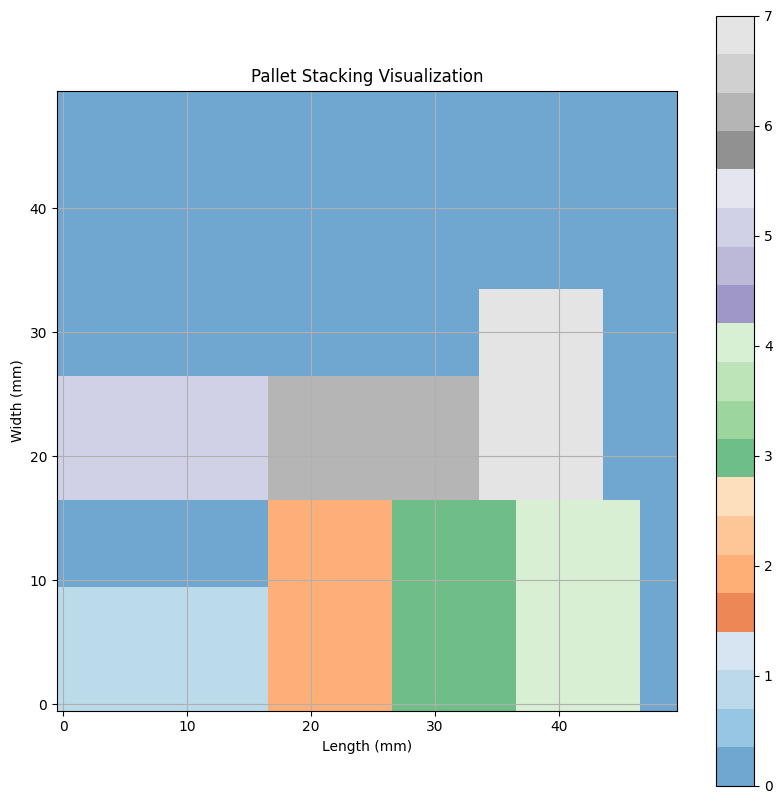

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def place_boxes(pallet_dimensions, box_dimensions, placements):
    LP, WP, HP = pallet_dimensions
    LB, WB, HB = box_dimensions

    pallet = np.zeros((LP, WP))  # Initialize pallet space (2D for now)
    current_x = 0
    current_y = 0
    row_height = 0

    for i, placement in enumerate(placements):
        if placement == "ID1":  # Horizontal placement
            box_length, box_width = LB, WB
        elif placement == "ID2":  # Vertical placement
            box_length, box_width = WB, LB
        else:
            raise ValueError("Invalid placement identifier. Use 'ID1' for horizontal and 'ID2' for vertical.")

        if current_x + box_length > LP:  # Move to the next row
            current_x = 0
            current_y += row_height
            row_height = 0

        if current_y + box_width > WP:
            raise ValueError("No sufficient space on the pallet to place the box.")

        pallet[current_x:current_x+box_length, current_y:current_y+box_width] = i + 1

        current_x += box_length
        row_height = max(row_height, box_width)

    return pallet

def plot_pallet(pallet):
    plt.figure(figsize=(10, 10))
    plt.imshow(pallet.T, origin="lower", cmap="tab20c", alpha=0.7)
    plt.colorbar()
    plt.title("Pallet Stacking Visualization")
    plt.xlabel("Length (mm)")
    plt.ylabel("Width (mm)")
    plt.grid(True)
    plt.show()

# Test case
pallet_dimensions = (50, 50, 30)  # Length, Width, Height
box_dimensions = (10, 17, 10)       # Length, Width, Height

placements = ["ID2", "ID1", "ID1", "ID1", "ID2"]
# placements = ["ID2", "ID1", "ID1", "ID1", "ID2", "ID1", "ID2", "ID1", "ID2" ,"ID1"]
# placements = ["ID2", "ID1", "ID1", "ID1", "ID2", "ID1", "ID2", "ID1", "ID2" ,"ID1", "ID2"]
# placements = ["ID2", "ID1", "ID1", "ID1", "ID2", "ID1", "ID2", "ID1", "ID2" ,"ID1", "ID2", "ID1"]
# placements = ["ID2", "ID1", "ID1", "ID1", "ID2", "ID1", "ID2", "ID1", "ID2" ,"ID1", "ID2", "ID1", "ID1"]
# placements = ["ID2", "ID1", "ID1", "ID1", "ID2", "ID1", "ID2", "ID1", "ID2" ,"ID1", "ID2", "ID1", "ID1", "ID2", "ID1"]
placements = ["ID2", "ID1", "ID1", "ID1", "ID2", "ID2"]
placements = ["ID2", "ID1", "ID1", "ID1", "ID2", "ID2", "ID1",]

pallet = place_boxes(pallet_dimensions, box_dimensions, placements)
plot_pallet(pallet)


ALGORITHM 2: BOX ARRANGEMENT II

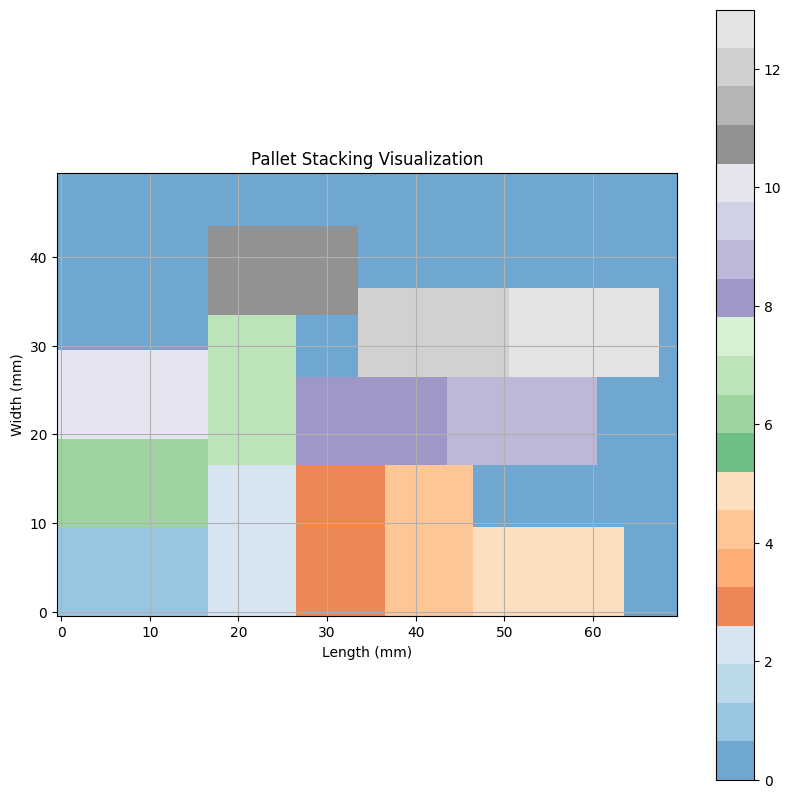

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def place_boxes(pallet_dimensions, box_dimensions, placements):
    LP, WP, HP = pallet_dimensions
    LB, WB, HB = box_dimensions

    pallet = np.zeros((LP, WP))  # Initialize pallet space (2D for now)
    height_map = [0] * LP  # Tracks the height at each x-coordinate
    current_x = 0

    for i, placement in enumerate(placements):
        if placement == "ID1":  # Horizontal placement
            box_length, box_width = LB, WB
        elif placement == "ID2":  # Vertical placement
            box_length, box_width = WB, LB
        else:
            raise ValueError("Invalid placement identifier. Use 'ID1' for horizontal and 'ID2' for vertical.")

        # Check if the box fits in the remaining pallet length
        if current_x + box_length > LP:
            current_x = 0  # Move to the beginning of the next row

        # Find the lowest y position along the length of the box
        min_height = max(height_map[current_x:current_x + box_length])
        current_y = min_height

        # Check if the box fits within the pallet's width
        if current_y + box_width > WP:
            raise ValueError("No sufficient space on the pallet to place the box.")

        # Place the box in the pallet
        pallet[current_x:current_x+box_length, current_y:current_y+box_width] = i + 1

        # Update the height map
        for x in range(current_x, current_x + box_length):
            height_map[x] = max(height_map[x], current_y + box_width)

        # Move current_x to the next position
        current_x += box_length

    return pallet

def plot_pallet(pallet):
    plt.figure(figsize=(10, 10))
    plt.imshow(pallet.T, origin="lower", cmap="tab20c", alpha=0.7)
    plt.colorbar()
    plt.title("Pallet Stacking Visualization")
    plt.xlabel("Length (mm)")
    plt.ylabel("Width (mm)")
    plt.grid(True)
    plt.show()

# Test case
pallet_dimensions = (70, 50, 30)  # Pallet dimensions: L x W x H # Length, Width, Height
box_dimensions = (10, 17, 10)     # Box dimensions: L x W x H # Length, Width, Height

placements = ["ID2", "ID1", "ID1", "ID1", "ID2"]
placements = ["ID2", "ID1", "ID1", "ID1", "ID2", "ID2"]
placements = ["ID2", "ID1", "ID1", "ID1", "ID2", "ID2", "ID1"]
placements = ["ID2", "ID1", "ID1", "ID1", "ID2", "ID2", "ID1", "ID2"]
placements = ["ID2", "ID1", "ID1", "ID1", "ID2", "ID2", "ID1", "ID2", "ID2", "ID2"]
placements = ["ID2", "ID1", "ID1", "ID1", "ID2", "ID2", "ID1", "ID2", "ID2", "ID2", "ID2"]
placements = ["ID2", "ID1", "ID1", "ID1", "ID2", "ID2", "ID1", "ID2", "ID2", "ID2", "ID2", "ID2", "ID2"]


pallet = place_boxes(pallet_dimensions, box_dimensions, placements)
plot_pallet(pallet)


ALGORITHM 3: END EFFECTOR PLACE POSES

In [85]:
def calculate_end_effector_poses(pallet, box_dimensions, pallet_pose):
    LB, WB, HB = box_dimensions
    x0, y0, z0, a0, b0, c0 = pallet_pose
    poses = []

    unique_labels = np.unique(pallet)[1:]  # Exclude the initial zero
    placed_boxes = set()

    for label in unique_labels:
        if label in placed_boxes:
            continue  # Skip already placed boxes

        box_position = np.argwhere(pallet == label)
        x_min, y_min = np.min(box_position, axis=0)
        x_max, y_max = np.max(box_position, axis=0)

        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        angle = 90 if (x_max - x_min + 1) == WB else 0

        # Check for neighbors in the same row or column
        neighbors = [(label, x_min, y_min, x_max, y_max)]
        for offset in range(1, 3):  # Check up to 2 neighbors
            next_label = label + offset
            if next_label in unique_labels and next_label not in placed_boxes:
                next_position = np.argwhere(pallet == next_label)
                nx_min, ny_min = np.min(next_position, axis=0)
                nx_max, ny_max = np.max(next_position, axis=0)

                if angle == 0 and ny_min == y_min:  # Same row for vertical pick
                    neighbors.append((next_label, nx_min, ny_min, nx_max, ny_max))
                elif angle == 90 and nx_min == x_min:  # Same column for horizontal pick
                    neighbors.append((next_label, nx_min, ny_min, nx_max, ny_max))
                else:
                    break
            else:
                break

        if len(neighbors) > 1:
            combined_x_center = sum((n[3] + n[1]) for n in neighbors) / (2 * len(neighbors))
            combined_y_center = sum((n[4] + n[2]) for n in neighbors) / (2 * len(neighbors))
            poses.append((x0 + combined_x_center, y0 + combined_y_center, z0, a0, b0, c0 + angle))
            placed_boxes.update(n[0] for n in neighbors)
        else:
            poses.append((x0 + x_center, y0 + y_center, z0, a0, b0, c0 + angle))
            placed_boxes.add(label)

    return poses


ALGORITHM 4: OPTIMIZE HORIZONTAL PLACE POSES

In [86]:
def optimize_poses(poses, limit=3):
    """
    Optimize end-effector poses for efficient robot picking.

    Parameters:
    poses (list of tuples): List of poses where each pose is a tuple (x, y, z, roll, pitch, yaw).
    limit (int): Maximum number of poses the robot can handle in one group.

    Returns:
    list of tuples: Optimized poses for the robot.
    """
    # Separate poses by orientation
    horizontal_poses = [pose for pose in poses if pose[5] == 0]  # y-aligned poses (0 degree)
    vertical_poses = [pose for pose in poses if pose[5] == 90]  # x-aligned poses (90 degree)

    optimized_poses = []

    # Handle horizontal poses (0 degrees)
    optimized_poses.extend(horizontal_poses)

    # Handle vertical poses (90 degrees)
    if vertical_poses:
        # Sort vertical poses based on their x-coordinate (this helps with grouping them)
        vertical_poses = sorted(vertical_poses, key=lambda x: x[0])

        # Group poses with nearby x and average their y values
        current_group = [vertical_poses[0]]
        for pose in vertical_poses[1:]:
            # Check if the current pose is close enough to the last one in the group
            if abs(pose[0] - current_group[-1][0]) < 10:  # you can adjust this threshold
                current_group.append(pose)
            else:
                # Process the current group if it exceeds the limit
                while len(current_group) > limit:
                    subgroup = current_group[:limit]
                    avg_y = np.mean([p[1] for p in subgroup])
                    optimized_poses.append((subgroup[0][0], avg_y, 0, 0, 0, 90))
                    current_group = current_group[limit:]

                # Average the remaining poses in the current group
                if current_group:
                    avg_y = np.mean([p[1] for p in current_group])
                    optimized_poses.append((current_group[0][0], avg_y, 0, 0, 0, 90))
                current_group = [pose]

        # Don't forget to process the last group
        while len(current_group) > limit:
            subgroup = current_group[:limit]
            avg_y = np.mean([p[1] for p in subgroup])
            optimized_poses.append((subgroup[0][0], avg_y, 0, 0, 0, 90))
            current_group = current_group[limit:]

        if current_group:
            avg_y = np.mean([p[1] for p in current_group])
            optimized_poses.append((current_group[0][0], avg_y, 0, 0, 0, 90))

    return optimized_poses


TEST CASE 1:

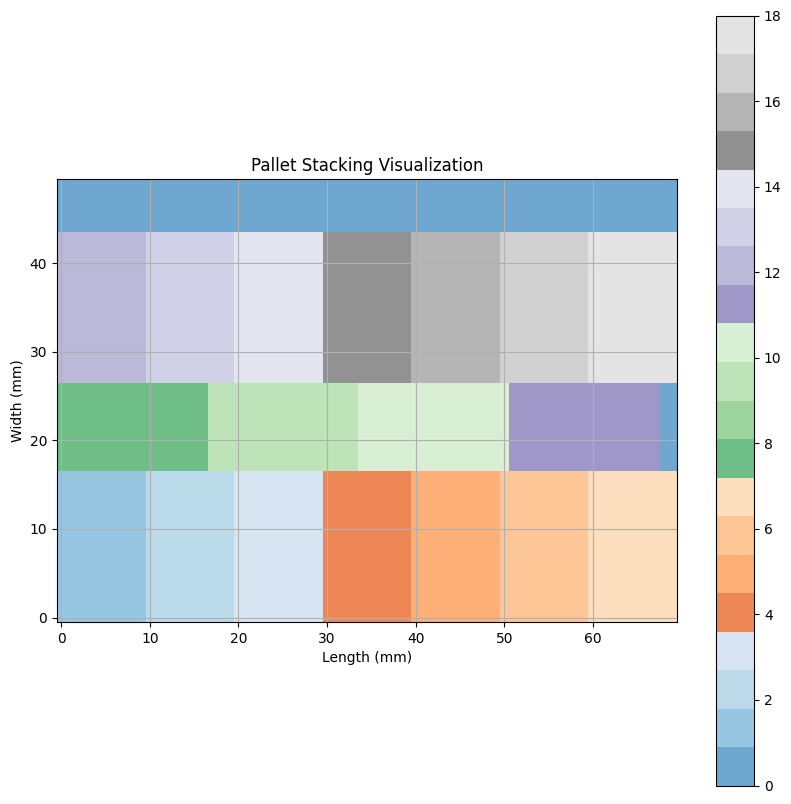

Optimized End Effector Pose: (np.float64(14.5), np.float64(8.0), 0, 0, 0, 0)
Optimized End Effector Pose: (np.float64(44.5), np.float64(8.0), 0, 0, 0, 0)
Optimized End Effector Pose: (np.float64(64.5), np.float64(8.0), 0, 0, 0, 0)
Optimized End Effector Pose: (np.float64(14.5), np.float64(35.0), 0, 0, 0, 0)
Optimized End Effector Pose: (np.float64(44.5), np.float64(35.0), 0, 0, 0, 0)
Optimized End Effector Pose: (np.float64(64.5), np.float64(35.0), 0, 0, 0, 0)
Optimized End Effector Pose: (np.float64(8.0), np.float64(21.5), 0, 0, 0, 90)
Optimized End Effector Pose: (np.float64(25.0), np.float64(21.5), 0, 0, 0, 90)
Optimized End Effector Pose: (np.float64(42.0), np.float64(21.5), 0, 0, 0, 90)
Optimized End Effector Pose: (np.float64(59.0), np.float64(21.5), 0, 0, 0, 90)


In [ ]:
# Test case
pallet_dimensions = (70, 50, 30)  # Pallet dimensions: L x W x H
box_dimensions = (10, 17, 10)     # Box dimensions: L x W x H

placements = ["ID1", "ID1", "ID1", "ID1", "ID1", "ID1", "ID1",
              "ID2", "ID2", "ID2", "ID2",
            #   "ID2", "ID2", "ID2", "ID2",
            #   "ID2", "ID2", "ID2", "ID2"]
            "ID1", "ID1", "ID1", "ID1", "ID1", "ID1", "ID1",]

pallet = place_boxes(pallet_dimensions, box_dimensions, placements)
plot_pallet(pallet)

# Sample Pallet Pose (top-left corner reference)
pallet_pose = (0, 0, 0, 0, 0, 0)
end_effector_poses = calculate_end_effector_poses(pallet, box_dimensions, pallet_pose)

# Optimize the poses
optimized_poses = optimize_poses(end_effector_poses)

# Print the optimized poses
for pose in optimized_poses:
    print("Optimized End Effector Pose:", pose)


TEST CASE 2:

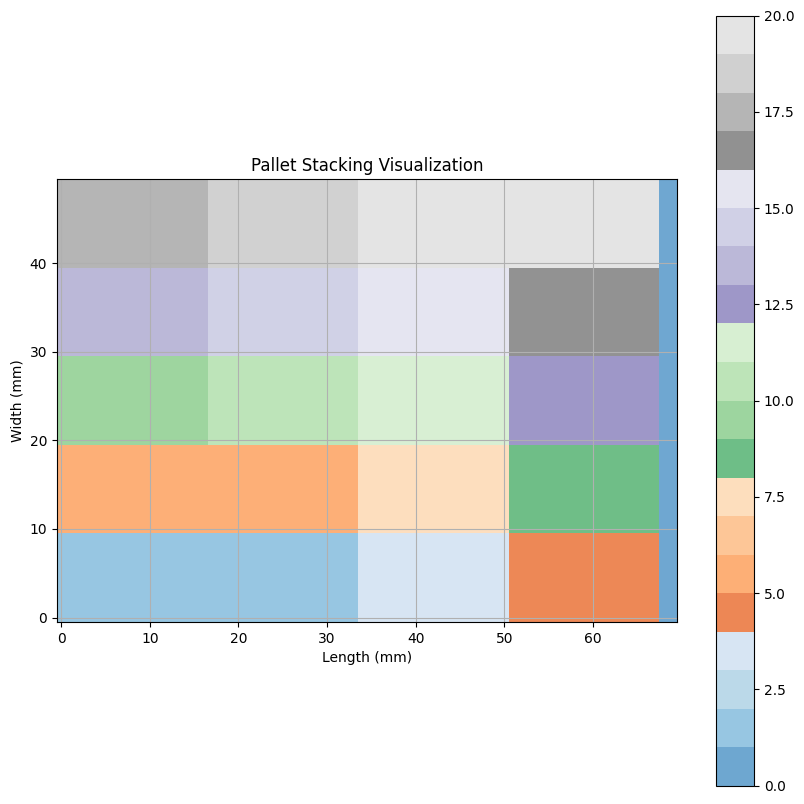

 
Optimized End Effector Pose: (np.float64(8.0), np.float64(14.5), 0, 0, 0, 90)
Optimized End Effector Pose: (np.float64(8.0), np.float64(39.5), 0, 0, 0, 90)
Optimized End Effector Pose: (np.float64(25.0), np.float64(14.5), 0, 0, 0, 90)
Optimized End Effector Pose: (np.float64(25.0), np.float64(39.5), 0, 0, 0, 90)
Optimized End Effector Pose: (np.float64(42.0), np.float64(14.5), 0, 0, 0, 90)
Optimized End Effector Pose: (np.float64(42.0), np.float64(39.5), 0, 0, 0, 90)
Optimized End Effector Pose: (np.float64(59.0), np.float64(14.5), 0, 0, 0, 90)
Optimized End Effector Pose: (np.float64(59.0), np.float64(39.5), 0, 0, 0, 90)


In [ ]:
# Test case
pallet_dimensions = (70, 50, 30)  # Pallet dimensions: L x W x H
box_dimensions = (10, 17, 10)     # Box dimensions: L x W x H

placements = ["ID2", "ID2", "ID2", "ID2", # ["ID1", "ID1", "ID1", "ID1", "ID1", "ID1", "ID1",
               "ID2", "ID2", "ID2", "ID2",
               "ID2", "ID2", "ID2", "ID2",
               "ID2", "ID2", "ID2", "ID2",
               "ID2", "ID2", "ID2", "ID2"]
            # "ID1", "ID1", "ID1", "ID1", "ID1", "ID1", "ID1",]

pallet = place_boxes(pallet_dimensions, box_dimensions, placements)
plot_pallet(pallet)

# Sample Pallet Pose (top-left corner reference)
pallet_pose = (0, 0, 0, 0, 0, 0)
end_effector_poses = calculate_end_effector_poses(pallet, box_dimensions, pallet_pose)

# Print the optimized poses
# for pose in end_effector_poses:
#     print("End Effector Pose:", pose)

# Optimize the poses
optimized_poses = optimize_poses(end_effector_poses)

print(" ")
# Print the optimized poses
for pose in optimized_poses:
    print("Optimized End Effector Pose:", pose)


TEST CASE 3:

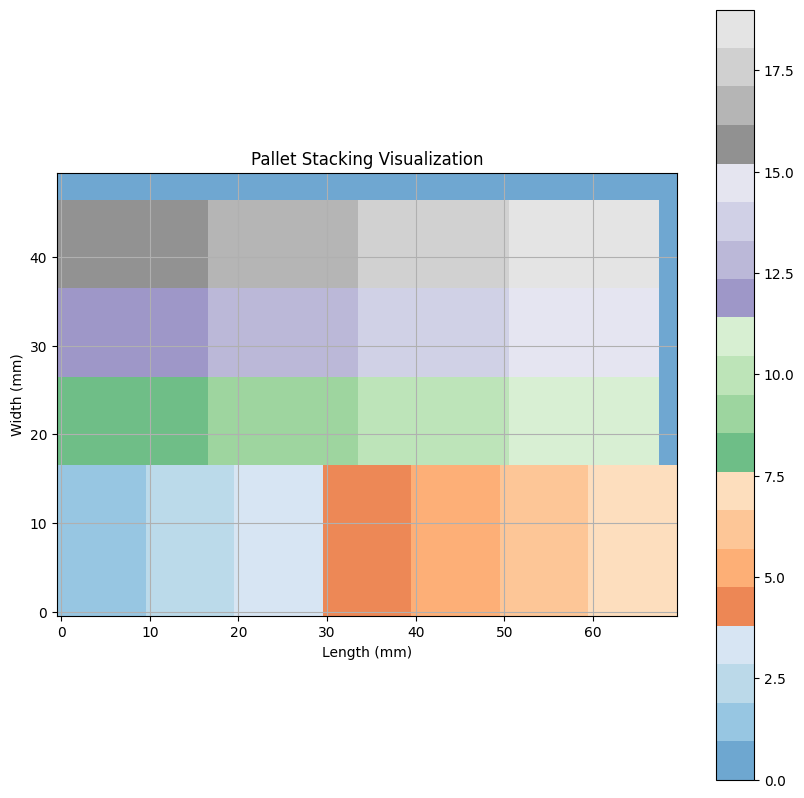

 
Optimized End Effector Pose: (np.float64(14.5), np.float64(8.0), 0, 0, 0, 0)
Optimized End Effector Pose: (np.float64(44.5), np.float64(8.0), 0, 0, 0, 0)
Optimized End Effector Pose: (np.float64(64.5), np.float64(8.0), 0, 0, 0, 0)
Optimized End Effector Pose: (np.float64(8.0), np.float64(31.5), 0, 0, 0, 90)
Optimized End Effector Pose: (np.float64(25.0), np.float64(31.5), 0, 0, 0, 90)
Optimized End Effector Pose: (np.float64(42.0), np.float64(31.5), 0, 0, 0, 90)
Optimized End Effector Pose: (np.float64(59.0), np.float64(31.5), 0, 0, 0, 90)


In [ ]:
# Test case
pallet_dimensions = (70, 50, 30)  # Pallet dimensions: L x W x H
box_dimensions = (10, 17, 10)     # Box dimensions: L x W x H

placements = ["ID1", "ID1", "ID1", "ID1", "ID1", "ID1", "ID1",
              "ID2", "ID2", "ID2", "ID2",
               "ID2", "ID2", "ID2", "ID2",
               "ID2", "ID2", "ID2", "ID2"]
            # "ID1", "ID1", "ID1", "ID1", "ID1", "ID1", "ID1",]

pallet = place_boxes(pallet_dimensions, box_dimensions, placements)
plot_pallet(pallet)

# Sample Pallet Pose (top-left corner reference)
pallet_pose = (0, 0, 0, 0, 0, 0)
end_effector_poses = calculate_end_effector_poses(pallet, box_dimensions, pallet_pose)

# Optimize the poses
optimized_poses = optimize_poses(end_effector_poses)

print(" ")
# Print the optimized poses
for pose in optimized_poses:
    print("Optimized End Effector Pose:", pose)

TEST CASE 4:

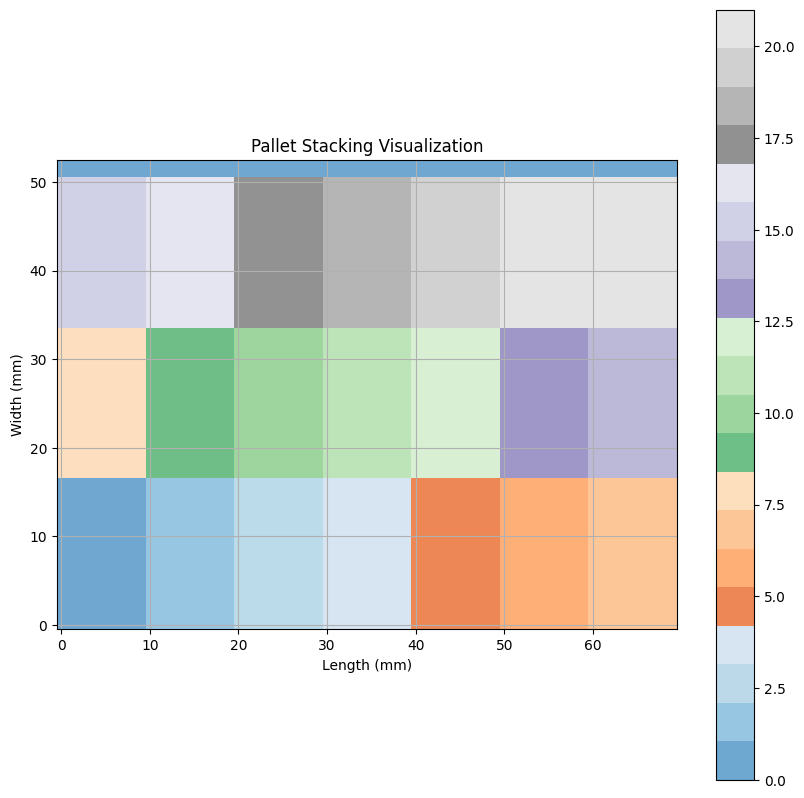

Optimized End Effector Pose: (np.float64(14.5), np.float64(8.0), 0, 0, 0, 0)
Optimized End Effector Pose: (np.float64(44.5), np.float64(8.0), 0, 0, 0, 0)
Optimized End Effector Pose: (np.float64(64.5), np.float64(8.0), 0, 0, 0, 0)
Optimized End Effector Pose: (np.float64(14.5), np.float64(25.0), 0, 0, 0, 0)
Optimized End Effector Pose: (np.float64(44.5), np.float64(25.0), 0, 0, 0, 0)
Optimized End Effector Pose: (np.float64(64.5), np.float64(25.0), 0, 0, 0, 0)
Optimized End Effector Pose: (np.float64(14.5), np.float64(42.0), 0, 0, 0, 0)
Optimized End Effector Pose: (np.float64(44.5), np.float64(42.0), 0, 0, 0, 0)
Optimized End Effector Pose: (np.float64(64.5), np.float64(42.0), 0, 0, 0, 0)


In [ ]:
# Test case
pallet_dimensions = (70, 53, 30)  # Pallet dimensions: L x W x H
box_dimensions = (10, 17, 10)     # Box dimensions: L x W x H

placements = ["ID1", "ID1", "ID1", "ID1", "ID1", "ID1", "ID1",
              "ID1", "ID1", "ID1", "ID1", "ID1", "ID1", "ID1",
            #  "ID2", "ID2", "ID2", "ID2",
            #   "ID2", "ID2", "ID2", "ID2",
            #   "ID2", "ID2", "ID2", "ID2"]
            "ID1", "ID1", "ID1", "ID1", "ID1", "ID1", "ID1",]

pallet = place_boxes(pallet_dimensions, box_dimensions, placements)
plot_pallet(pallet)

# Sample Pallet Pose (top-left corner reference)
pallet_pose = (0, 0, 0, 0, 0, 0)
end_effector_poses = calculate_end_effector_poses(pallet, box_dimensions, pallet_pose)

# Optimize the poses
optimized_poses = optimize_poses(end_effector_poses)

# Print the optimized poses
for pose in optimized_poses:
    print("Optimized End Effector Pose:", pose)

In [ ]:
import logging
import sys
import os

class FactsheetSubscriber:
    def __init__(self, fleetname, versions, output_to_screen=True):
        self.fleetname = fleetname
        self.versions = versions
        self.output_to_screen = output_to_screen
        self.logger = logging.getLogger("FactsheetSubscriber")
        self.logger.setLevel(logging.INFO)

        # Ensure handlers are not duplicated
        if not self.logger.hasHandlers():
            # Set up logging to log file
            log_file_path = os.path.abspath("FmLogHandler.log")
            file_mode = 'a' if os.path.exists(log_file_path) else 'w'

            file_handler = logging.FileHandler(log_file_path, mode=file_mode)
            file_handler.setFormatter(
                logging.Formatter("[%(asctime)s] %(levelname)s in %(name)s: %(message)s")
            )
            self.logger.addHandler(file_handler)

            if self.output_to_screen:
                # Output to terminal (stdout)
                stream_handler = logging.StreamHandler(sys.stdout)
                stream_handler.setFormatter(
                    logging.Formatter("[%(asctime)s] %(levelname)s in %(name)s: %(message)s")
                )
                self.logger.addHandler(stream_handler)

            # Show log file path
            self.logger.info(f"[FactsheetSubscriber] Logs are written to: {log_file_path}")

        # Example subscription call
        self.subscribe("vex4u")

    def subscribe(self, topic):
        """Subscribe to a topic."""
        self.logger.info("[FactsheetSubscriber] Subscribed to topic: %s", topic)

    def close(self):
        """Ensure the log file is properly closed."""
        for handler in self.logger.handlers[:]:
            handler.close()
            self.logger.removeHandler(handler)

# Example Usage
subscriber = FactsheetSubscriber("FleetX", "v1", output_to_screen=True)  # Set this to False to avoid terminal output

# Close handlers when done
subscriber.close()


In [ ]:
#!/usr/bin/env python3

import unittest
from unittest.mock import Mock, MagicMock, patch
from FmTaskHandler import FmTaskHandler


class TestFmTaskHandler(unittest.TestCase):

    def setUp(self):
        """Set up test environment before each test case."""
        self.mock_dbconn = MagicMock()  # Mock database connection
        self.mock_mqttclient = MagicMock()  # Mock MQTT client
        self.mock_task_dict = {"itinerary": [{"fleet_id": "f1", "loc_id": "L1", "coordinate": [1.0, 2.0]}]}

        # Initialize FmTaskHandler with mock dependencies
        self.task_handler = FmTaskHandler(
            fleetname="kullar",
            version="1.0.0",
            versions="v1",
            manufacturer="birfen",
            dbconn=self.mock_dbconn,
            mqttclient=self.mock_mqttclient,
            task_dict=self.mock_task_dict
        )

        # Mock other handlers used in the methods
        self.task_handler.visualization_handler = MagicMock()
        self.task_handler.connection_handler = MagicMock()
        self.task_handler.state_handler = MagicMock()
        self.task_handler.order_handler = MagicMock()
        self.task_handler.instant_actions_handler = MagicMock()
        self.task_handler.factsheet_handler = MagicMock()

    def test_verify_robot_fitness(self):
        """Test verify_robot_fitness method."""

        # Mock data returned by dependencies
        self.task_handler.connection_handler.fetch_data.return_value = ("ONLINE", None)
        self.task_handler.state_handler.fetch_data.return_value = (
            None, None, "order123", "node1", None, None, None,
            {'x': 1.0, 'y': 2.0, 'theta': 0.5}, None, {'batteryCharge': 40}, None, None
        )
        # Correctly mock the method
        self.task_handler.find_nearest_node = Mock()
        self.task_handler.find_nearest_node.return_value = (None, "node_owner", ["home1"], ["charge1"], ["station1"])
        self.task_handler.get_if_home = MagicMock(return_value=True)

        # Call the method
        result = self.task_handler.verify_robot_fitness("f1", "robot1", "m1", "task_name")

        # Assertions
        self.assertTrue(result[0])  # cleared status
        self.assertEqual(result[1], [1.0, 2.0, 0.5])  # current position
        self.assertEqual(result[2], 40)  # battery charge

    def test_suggest_robot(self):
        """Test suggest_robot method."""
        # Mock return values
        self.task_handler.factsheet_handler.fetch_serial_numbers.return_value = ["robot1", "robot2"]
        self.task_handler.verify_robot_fitness = MagicMock(side_effect=[
            (True, [1.0, 2.0], 50, "node1", None, None, None, None, None),
            (True, [4.0, 5.0], 90, "node2", None, None, None, None, None)
        ])

        # Call the method
        result = self.task_handler.suggest_robot("f1", "robot3", "m1", "L1", "task_name", self.mock_task_dict)

        # Assertions
        self.assertEqual(result, ["robot1", "robot2"])  # Robots are sorted based on distance

    def test_fm_extract_unique_waitpoints(self):
        """Test fm_extract_unique_waitpoints method."""
        task_dict = {
            'graph': {
                'C1': [('W1', 2), ('C2', 3)],
                'C2': [('W2', 1)],
                'C3': [('N1', 1)]
            }
        }
        checkpoints = ['C1', 'C2']

        # Call the method
        result = self.task_handler.fm_extract_unique_waitpoints(checkpoints, task_dict)

        # Assertions
        self.assertEqual(set(result), {'W1', 'W2'})

    def test_fm_shortest_paths(self):
        """Test fm_shortest_paths method."""
        graph = {
            'A': [('B', 1), ('C', 4)],
            'B': [('C', 2), ('D', 5)],
            'C': [('D', 1)],
            'D': []
        }
        result = self.task_handler.fm_shortest_paths('A', 'D', graph, max_alternatives=2)

        # Assertions
        self.assertEqual(result, [['A', 'B', 'C', 'D'], ['A', 'B', 'D']])

if __name__ == "__main__":
    unittest.main()

In [ ]:
import logging
import paho.mqtt.client as mqtt

logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

class FmMain:
    def __init__(self):
        self.mqtt_address = "127.0.0.1"
        self.mqtt_port = 1883
        self.mqtt_client = mqtt.Client()

    def mqtt_connect(self):
        try:
            self.mqtt_client.connect(self.mqtt_address, self.mqtt_port, keepalive=60)
            logger.info("MQTT connection successful")
        except Exception as e:
            logger.error(f"MQTT connection failed: {e}")

    def run(self):
        self.mqtt_connect()
        # Your code to handle MQTT messages

if __name__ == "__main__":
    fm_main = FmMain()
    fm_main.run()


In [ ]:
import yaml

def update_yaml_graph_and_itinerary(yaml_file_path, updated_graph, updated_itinerary):
    """
    Updates the 'graph' and 'itinerary' sections in a YAML file.

    Parameters:
        yaml_file_path (str): Path to the YAML file.
        updated_graph (dict): Updated graph data.
        updated_itinerary (list): Updated itinerary data.
    """
    try:
        # Read the existing YAML file
        with open(yaml_file_path, 'r') as file:
            yaml_content = yaml.safe_load(file)

        # Update only the graph and itinerary sections
        yaml_content['graph'] = updated_graph
        yaml_content['itinerary'] = updated_itinerary

        # Write the updated content back to the YAML file
        with open(yaml_file_path, 'w') as file:
            yaml.safe_dump(yaml_content, file, default_flow_style=False, sort_keys=False)

        print(f"[INFO] Successfully updated 'graph' and 'itinerary' in {yaml_file_path}")

    except Exception as e:
        print(f"[ERROR] Failed to update the YAML file: {e}")

updated_graph = {
    "C1": [["C2", 7.5], ["C3", 0.3]],
    "C2": [["C1", 0.5], ["C4", 0.4]],
    "C3": [["C1", 0.3]]
}

updated_itinerary = [
    {"coordinate": [[-0.5, -0.5, -0.2, 0.98]], "description": "checkpoint", "fleet_id": "kullar", "map_id": "bina_1_floor_0", "loc_id": "C1"},
    {"coordinate": [[0.5, -0.5, -0.1, 0.99]], "description": "station_dock", "fleet_id": "kullar", "map_id": "bina_1_floor_0", "loc_id": "C2"}
]

yaml_file_path = '/home/hazeezadebayo/Desktop/fleet_management_v5/fleet_management/config/config.yaml'

update_yaml_graph_and_itinerary(yaml_file_path, updated_graph, updated_itinerary)


In [ ]:
import random

def plot_graph_ascii(graph, itinerary, robot_positions):
    # Step 1: Extract node positions from the itinerary
    node_positions = {item['loc_id']: (item['coordinate'][0], item['coordinate'][1]) for item in itinerary}

    # Step 2: Normalize coordinates to fit into a 2D ASCII grid
    all_x = [coord[0] for coord in node_positions.values()]
    all_y = [coord[1] for coord in node_positions.values()]
    min_x, max_x = min(all_x), max(all_x)
    min_y, max_y = min(all_y), max(all_y)

    grid_width = 50
    grid_height = 20

    def normalize(val, min_val, max_val, grid_size):
        return int((val - min_val) / (max_val - min_val) * (grid_size - 1))

    grid = [[' ' for _ in range(grid_width)] for _ in range(grid_height)]

    # Step 3: Place nodes on the grid with conflict resolution
    node_grid_positions = {}
    occupied_positions = set()

    for node, (x, y) in node_positions.items():
        gx = normalize(x, min_x, max_x, grid_width)
        gy = normalize(y, min_y, max_y, grid_height)

        # Resolve conflicts by shifting to the nearest free space
        while (gx, gy) in occupied_positions:
            gx += 1
            if gx >= grid_width:  # Wrap around if out of bounds
                gx = 0
                gy += 1
            if gy >= grid_height:  # Prevent overflow
                gy = 0

        occupied_positions.add((gx, gy))
        node_grid_positions[node] = (gx, gy)
        grid[gy][gx] = node

    # Step 4: Draw edges between nodes
    def draw_line(grid, x1, y1, x2, y2):
        points = list(bresenham(x1, y1, x2, y2))
        for px, py in points:
            if grid[py][px] == ' ':  # Avoid overwriting node names
                grid[py][px] = '.'

    def bresenham(x1, y1, x2, y2):
        """Bresenham's line algorithm."""
        dx = abs(x2 - x1)
        dy = abs(y2 - y1)
        sx = 1 if x1 < x2 else -1
        sy = 1 if y1 < y2 else -1
        err = dx - dy
        while True:
            yield x1, y1
            if x1 == x2 and y1 == y2:
                break
            e2 = 2 * err
            if e2 > -dy:
                err -= dy
                x1 += sx
            if e2 < dx:
                err += dx
                y1 += sy

    for node, edges in graph.items():
        if node in node_grid_positions:
            x1, y1 = node_grid_positions[node]
            for edge in edges:
                neighbor = edge[0]
                if neighbor in node_grid_positions:
                    x2, y2 = node_grid_positions[neighbor]
                    draw_line(grid, x1, y1, x2, y2)

    # Step 5: Assign random colors to robots
    colors = ['\033[34m', '\033[33m', '\033[31m', '\033[32m', '\033[36m']
    robot_colors = {robot: random.choice(colors) for robot in robot_positions}

    # Step 6: Place robots on the grid
    for robot, position in robot_positions.items():
        node = position.get('loc_id')
        if node in node_grid_positions:
            gx, gy = node_grid_positions[node]
            grid[gy][gx] = f"{robot_colors[robot]}{robot}\033[0m"  # Add color and reset

    # Step 7: Render the grid
    for row in grid:
        print(''.join(row))

# Example Usage
graph = {
    'C1': [['C7', 0.4], ['C12', 0.1], ['C4', 0.1], ['C2', 0.1], ['W1', 0.1]],
    'C2': [['C1', 0.1], ['C9', 0.1], ['C6', 0.1], ['W2', 0.1]],
    'C3': [['C8', 0.1]],
    'C4': [['C8', 0.1], ['C1', 0.1], ['C11', 0.1], ['C6', 0.1], ['W4', 0.1]],
    'C5': [['C7', 0.1]],
    'C6': [['C10', 0.1], ['C4', 0.1], ['C2', 0.1], ['W6', 0.1]],
    'C7': [['C1', 0.1], ['C5', 0.1], ['W7', 0.1]],
    'C8': [['C3', 0.1], ['C4', 0.1], ['W8', 0.1]],
    'C9': [['C2', 0.1]],
    'C10': [['C6', 0.1]],
    'C11': [['C4', 0.1]],
    'C12': [['C1', 0.1]],
    'W1': [['C1', 0.1]],
    'W2': [['C2', 0.1]],
    'W4': [['C4', 0.1]],
    'W6': [['C6', 0.1]],
    'W7': [['C7', 0.1]],
    'W8': [['C8', 0.1]],
}

itinerary = [
    {'coordinate': [-0.55, -0.55, -0.194, 0.98], 'description': 'checkpoint', 'fleet_id': 'kullar', 'loc_id': 'C1'},
    {'coordinate': [0.55, -0.55, -0.097, 0.995], 'description': 'checkpoint', 'fleet_id': 'kullar', 'loc_id': 'C2'},
    {'coordinate': [0.5, 1.7, -0.097, 0.995], 'description': 'station_dock', 'fleet_id': 'kullar', 'loc_id': 'C3'},
    {'coordinate': [-0.53, 0.53, -0.097, 0.995], 'description': 'checkpoint', 'fleet_id': 'kullar', 'loc_id': 'C4'},
    {'coordinate': [0.5, -1.8, -0.097, 0.995], 'description': 'station_dock', 'fleet_id': 'kullar', 'loc_id': 'C5'},
    {'coordinate': [0.53, 0.53, -0.695, 0.718], 'description': 'checkpoint', 'fleet_id': 'kullar', 'loc_id': 'C6'},
    {'coordinate': [-0.5, -1.75, -0.695, 0.718], 'description': 'checkpoint', 'fleet_id': 'kullar', 'loc_id': 'C7'},
    {'coordinate': [-0.5, 1.8, 0.923, 0.004], 'description': 'checkpoint', 'fleet_id': 'kullar', 'loc_id': 'C8'},
    {'coordinate': [1.8, -0.57, 0.923, 0.004], 'description': 'charge_dock', 'fleet_id': 'kullar', 'loc_id': 'C9'},
    {'coordinate': [1.8, 0.49, -0.695, 0.718], 'description': 'charge_dock', 'fleet_id': 'kullar', 'loc_id': 'C10'},
    {'coordinate': [-1.7, 0.52, -0.999, 0.006], 'description': 'home_dock', 'fleet_id': 'kullar', 'loc_id': 'C11'},
    {'coordinate': [-1.5, -1.3, -0.999, 0.006], 'description': 'home_dock', 'fleet_id': 'kullar', 'loc_id': 'C12'},
    {'coordinate': [-0.55, -0.65, -0.194, 0.98], 'description': 'waitpoint', 'fleet_id': 'kullar', 'loc_id': 'W1'},
    {'coordinate': [0.55, -0.65, -0.097, 0.995], 'description': 'waitpoint', 'fleet_id': 'kullar', 'loc_id': 'W2'},
    {'coordinate': [-0.53, 0.63, -0.097, 0.995], 'description': 'waitpoint', 'fleet_id': 'kullar', 'loc_id': 'W4'},
    {'coordinate': [0.53, 0.63, -0.695, 0.718], 'description': 'waitpoint', 'fleet_id': 'kullar', 'loc_id': 'W6'},
    {'coordinate': [-0.5, -1.85, -0.695, 0.718], 'description': 'waitpoint', 'fleet_id': 'kullar', 'loc_id': 'W7'},
    {'coordinate': [-0.5, 1.9, 0.923, 0.004], 'description': 'waitpoint', 'fleet_id': 'kullar', 'loc_id': 'W8'},
]

robot_positions = {
    'R1': {'loc_id': 'C1'},
    'R2': {'loc_id': 'C5'},
}

plot_graph_ascii(graph, itinerary, robot_positions)

In [ ]:
import random

def plot_graph_ascii(graph, itinerary, robot_positions):
    # Step 1: Extract node positions from the itinerary
    node_positions = {item['loc_id']: (item['coordinate'][0], item['coordinate'][1]) for item in itinerary}

    # Step 2: Normalize coordinates to fit into a 2D ASCII grid
    all_x = [coord[0] for coord in node_positions.values()]
    all_y = [coord[1] for coord in node_positions.values()]
    min_x, max_x = min(all_x), max(all_x)
    min_y, max_y = min(all_y), max(all_y)

    grid_width = 50
    grid_height = 20

    def normalize(val, min_val, max_val, grid_size):
        return int((val - min_val) / (max_val - min_val) * (grid_size - 1))

    grid = [[' ' for _ in range(grid_width)] for _ in range(grid_height)]

    # Step 3: Place nodes on the grid with conflict resolution
    node_grid_positions = {}
    occupied_positions = set()

    for node, (x, y) in node_positions.items():
        gx = normalize(x, min_x, max_x, grid_width)
        gy = normalize(y, min_y, max_y, grid_height)

        # Resolve conflicts by shifting to the nearest free space
        while (gx, gy) in occupied_positions:
            gx += 1
            if gx >= grid_width:  # Wrap around if out of bounds
                gx = 0
                gy += 1
            if gy >= grid_height:  # Prevent overflow
                gy = 0

        occupied_positions.add((gx, gy))
        node_grid_positions[node] = (gx, gy)
        grid[gy][gx] = node

    # Step 4: Draw edges between nodes
    def draw_line(grid, x1, y1, x2, y2):
        points = list(bresenham(x1, y1, x2, y2))
        for px, py in points:
            if grid[py][px] == ' ':  # Avoid overwriting node names
                grid[py][px] = '.'

    def bresenham(x1, y1, x2, y2):
        """Bresenham's line algorithm."""
        dx = abs(x2 - x1)
        dy = abs(y2 - y1)
        sx = 1 if x1 < x2 else -1
        sy = 1 if y1 < y2 else -1
        err = dx - dy
        while True:
            yield x1, y1
            if x1 == x2 and y1 == y2:
                break
            e2 = 2 * err
            if e2 > -dy:
                err -= dy
                x1 += sx
            if e2 < dx:
                err += dx
                y1 += sy

    for node, edges in graph.items():
        if node in node_grid_positions:
            x1, y1 = node_grid_positions[node]
            for edge in edges:
                neighbor = edge[0]
                if neighbor in node_grid_positions:
                    x2, y2 = node_grid_positions[neighbor]
                    draw_line(grid, x1, y1, x2, y2)

    # Step 5: Assign random colors to robots
    colors = ['\033[34m', '\033[33m', '\033[31m', '\033[32m', '\033[36m']
    robot_colors = {robot: random.choice(colors) for robot in robot_positions}

    # Step 6: Place robots on the grid using their x, y coordinates
    for robot, position in robot_positions.items():
        rx, ry = position['x'], position['y']
        gx = normalize(rx, min_x, max_x, grid_width)
        gy = normalize(ry, min_y, max_y, grid_height)

        # Resolve conflicts with other robots
        while (gx, gy) in occupied_positions:
            gx += 1
            if gx >= grid_width:  # Wrap around if out of bounds
                gx = 0
                gy += 1
            if gy >= grid_height:  # Prevent overflow
                gy = 0

        occupied_positions.add((gx, gy))
        grid[gy][gx] = f"{robot_colors[robot]}{robot}\033[0m"  # Add color and reset

    # Step 7: Render the grid
    for row in grid:
        print(''.join(row))

# Example Usage
robot_positions = {
    'R1': {'x': -0.55, 'y': -0.55},
    'R2': {'x': 0.5, 'y': -1.8},
}

plot_graph_ascii(graph, itinerary, robot_positions)


In [ ]:
from datetime import datetime
def log_message(message, class_name, function_name, log_type="info"):
    """
    Custom logging function with ANSI escape codes for color formatting.

    Args:
        message (str): The message to log.
        class_name (str): The name of the class where the log originates.
        function_name (str): The name of the function where the log originates.
        log_type (str): The type of log (debug, warn, error, info). Determines color.
    """
    # ANSI color codes
    log_colors = {
        "debug": "\033[34m",  # Blue
        "warn": "\033[33m",   # Yellow
        "error": "\033[31m",  # Red
        "info": "\033[32m",   # Green
    }

    # Fallback color if type is unknown
    color = log_colors.get(log_type.lower(), "\033[37m")  # Default to white

    # Reset code
    reset = "\033[0m"

    # Current timestamp
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # Format class name in uppercase (no additional color change)
    class_name_formatted = class_name.upper()

    # Build and print the log message
    formatted_message = (
        f"{color}[{log_type.upper():<5}] {reset}"   # Log type with color
        f"\033[36m[{timestamp}]\033[0m "           # Timestamp in cyan
        f"\033[1m{class_name}.{function_name}\033[0m "  # Class and function bold
        f"- {message}"
    )
    print(formatted_message)

# Example usage
log_message("Executing HARD blocking action: action_type", "FmTaskHandler", "execute_hard_block", "debug")
log_message("Battery level lower than minimum required.", "FmTaskHandler", "check_battery", "warn")
log_message("Failed to decode order message", "FmTaskHandler", "decode_order", "error")
log_message("Reassigning loop task successfully.", "FmScheduleHandler", "reassign_loop_task", "info")


In [ ]:
move task should not validate home
time calculations with the /200?
before auto charge task ensure its not currently on a task

In [ ]:
parameters = {}
actionParameters = [{k : v} for k, v in parameters.items()]
print("- actionParameters -: ", actionParameters)

In [ ]:
traffic_control:  ['C4'] .
r_id:  AGV-002  reserved_checkpoint:
r_id:  AGV-002  agv_status:  red
r_id:  AGV-002  horizon:  ['C12', 'C1', 'C7', 'C5', 'C7', 'C1', 'C4', 'C8', 'C3', 'C8', 'C4', 'C1', 'C12']
r_id:  AGV-002  next_stop_id:  C12
r_id:  AGV-002  dist_to_base:  0.0
r_id:  AGV-002  has_order_minute_passed:  True
[FmTrafficHandler] ['AGV-002'] no conflict reservation. green.
[OrderPublisher] Publishing Order Message...
{
    "headerId": 2,
    "timestamp": "2024-11-26T00:32:41.552557",
    "version": "2.0.0",
    "manufacturer": "birfen",
    "serialNumber": "AGV-002",
    "orderId": "8cfe64d9-5858-4e63-ab28-39f9c5fe9f9a_1",
    "orderUpdateId": 1,
    "zoneSetId": "kullar",
    "nodes": [
        {
            "nodeId": "C12",
            "released": true,
            "sequenceId": 1,
            "nodeDescription": "Task Priority: low, Task Type: transport, Node Type: Checkpoint, Wait Time: None",
            "nodePosition": {
                "x": -1.5,
                "y": -1.3,
                "theta": -3.1295571143468925,
                "mapId": "map"
            },
            "actions": [
                {
                    "actionType": "dock",
                    "actionId": "5e56cba3-0580-43c1-a28d-517ba1a83e08",
                    "actionDescription": "task priority pick_place dock_location_info.",
                    "blockingType": "NONE",
                    "actionParameters": [
                        {
                            "key": "landmark",
                            "value": [
                                "low",
                                "transport",
                                "C5",
                                "C3",
                                "C12",
                                "C11"
                            ]
                        }
                    ]
                }
            ]
        },
        {
            "nodeId": "C12",
            "released": true,
            "sequenceId": 3,
            "nodeDescription": "Task Priority: low, Task Type: transport, Node Type: Checkpoint, Wait Time: None",
            "nodePosition": {
                "x": -1.5,
                "y": -1.3,
                "theta": -3.1295571143468925,
                "mapId": "map"
            },
            "actions": [
                {
                    "actionType": "dock",
                    "actionId": "5e56cba3-0580-43c1-a28d-517ba1a83e08",
                    "actionDescription": "task priority pick_place dock_location_info.",
                    "blockingType": "NONE",
                    "actionParameters": [
                        {
                            "key": "landmark",
                            "value": [
                                "low",
                                "transport",
                                "C5",
                                "C3",
                                "C12",
                                "C11"
                            ]
                        }
                    ]
                }
            ]
        }
    ],
    "edges": [
        {
            "edgeId": "edge_C12",
            "released": true,
            "sequenceId": 2,
            "startNodeId": "C12",
            "endNodeId": "C12",
            "actions": []
        }
    ]
}
traffic_control:  ['C4', 'C12'] .
r_id:  AGV-001  reserved_checkpoint:  C4
r_id:  AGV-001  agv_status:  green
r_id:  AGV-001  horizon:  ['C8', 'C3', 'C8', 'C4', 'C1', 'C7', 'C5', 'C7', 'C1', 'C4', 'C11']
r_id:  AGV-001  next_stop_id:  C8
r_id:  AGV-001  dist_to_base:  0.7700427342622999
r_id:  AGV-001  has_order_minute_passed:  False
traffic_control:  ['C4', 'C12'] .
r_id:  AGV-002  reserved_checkpoint:  C12
r_id:  AGV-002  agv_status:  green
r_id:  AGV-002  horizon:  ['C1', 'C7', 'C5', 'C7', 'C1', 'C4', 'C8', 'C3', 'C8', 'C4', 'C1', 'C12']
r_id:  AGV-002  next_stop_id:  C1
r_id:  AGV-002  dist_to_base:  0.0061552812808829075
r_id:  AGV-002  has_order_minute_passed:  False
traffic_control:  ['C4', 'C12'] .
r_id:  AGV-001  reserved_checkpoint:  C4
r_id:  AGV-001  agv_status:  green
r_id:  AGV-001  horizon:  ['C8', 'C3', 'C8', 'C4', 'C1', 'C7', 'C5', 'C7', 'C1', 'C4', 'C11']
r_id:  AGV-001  next_stop_id:  C8
r_id:  AGV-001  dist_to_base:  0.5700427342622998
r_id:  AGV-001  has_order_minute_passed:  False
traffic_control:  ['C4', 'C12'] .
r_id:  AGV-002  reserved_checkpoint:  C12
r_id:  AGV-002  agv_status:  red
r_id:  AGV-002  horizon:  ['C1', 'C7', 'C5', 'C7', 'C1', 'C4', 'C8', 'C3', 'C8', 'C4', 'C1', 'C12']
r_id:  AGV-002  next_stop_id:  C1
r_id:  AGV-002  dist_to_base:  0.0
r_id:  AGV-002  has_order_minute_passed:  False
[FmTaskHandler]: AGV-002: Last connection state: ONLINE
[FmTaskHandler]: robot position: -1.5, -1.3, -3.1295571143468925
[FmTaskHandler]: found shortest distance: 1.2103718436910205 with loc: C1
[FmTaskHandler]: found shortest distance: 1.0965856099730653 with loc: C7
[FmTaskHandler]: found shortest distance: 0.0 with loc: C12
[OrderPublisher] Deleted %d redundant orders, kept latest order: %s 1 8cfe64d9-5858-4e63-ab28-39f9c5fe9f9a_1
traffic_control:  ['C4', 'C12'] .
r_id:  AGV-001  reserved_checkpoint:  C4
r_id:  AGV-001  agv_status:  green
r_id:  AGV-001  horizon:  ['C8', 'C3', 'C8', 'C4', 'C1', 'C7', 'C5', 'C7', 'C1', 'C4', 'C11']
r_id:  AGV-001  next_stop_id:  C8
r_id:  AGV-001  dist_to_base:  0.37004273426229967
r_id:  AGV-001  has_order_minute_passed:  False
traffic_control:  ['C4', 'C12'] .

In [ ]:
xox = [1, 3, 6, 9]
oxo = [11, 13, 16, 19]
print(xox[:2])
for idx, node in enumerate(xox):
    print("idx: ", idx)
    print("oxo: ", oxo[idx], " . ", node)

In [ ]:
import heapq
from collections import defaultdict

def shortest_paths(start, goal, graph, max_alternatives=3):
    """ Find the shortest path and additional alternatives using Dijkstra's algorithm. """
    # Priority queue to store (distance, path)
    heap = [(0, [start])]
    # Set to store visited nodes to avoid loops
    visited = set()
    # List to store all found paths
    paths = []

    while heap and len(paths) < max_alternatives:
        current_distance, path = heapq.heappop(heap)
        node = path[-1]

        # If we reach the goal, save the path
        if node == goal:
            paths.append(path)
            continue

        # If node has been visited, skip it
        if node in visited:
            continue

        visited.add(node)

        # Explore neighbors
        for neighbor, weight in graph.get(node, []):
            if neighbor not in visited:
                new_path = path + [neighbor]
                new_distance = current_distance + weight
                heapq.heappush(heap, (new_distance, new_path))

    # If no path is found, return None
    if not paths:
        return None

    return paths

# Example usage and test
graph = {
    'A': [('B', 1), ('C', 2)],
    'B': [('D', 4)],
    'C': [('D', 1)],
    'D': []
}

start = 'A'
goal = 'D'

paths = shortest_paths(start, goal, graph)
print("PATHS: ", paths)
for i, path in enumerate(paths):
    print(f"Path {i + 1}: {path}")


In [ ]:
lst = ['A', 'C', 'D', 'A', 'B', 'D']
lst1 = lst[3:]
print("lst1: ", lst1)